# Bayesian Censoring Data Modeling

- https://kylejcaron.github.io/posts/censored_demand/2024-02-06-censored-demand.html
- https://www.uber.com/en-DE/blog/modeling-censored-time-to-event-data-using-pyro/
- https://forum.pyro.ai/t/censoring-model-observing-on-delta/1811
- https://gist.github.com/hesenp/90877ea3d5801214098fecd3b9e089bc

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.handlers import mask
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---

# Part I: Continuous Distribution

## Generate Censored Data

Text(0.5, 1.0, 'Censored Gamma Sample Data')

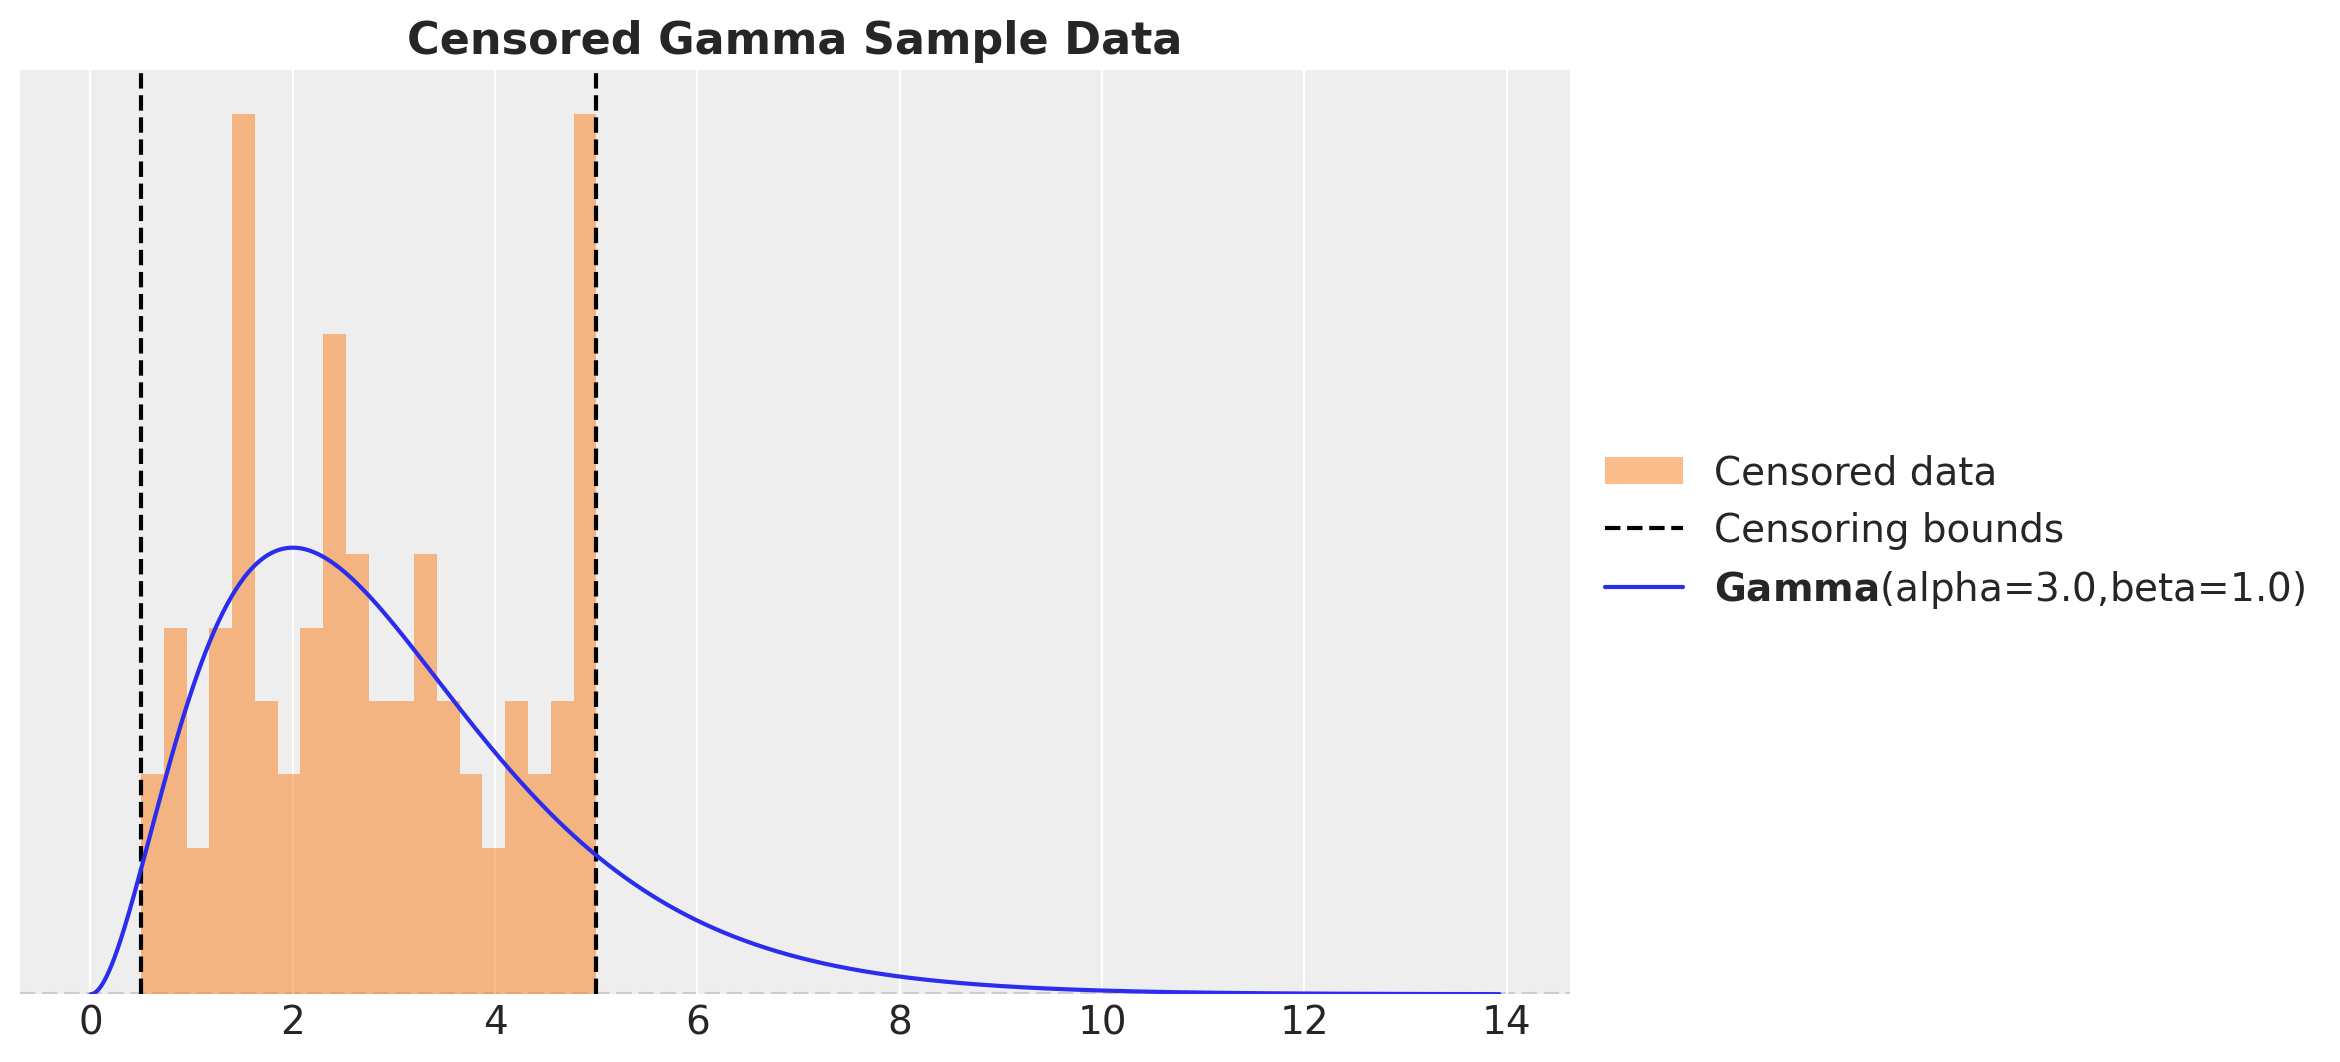

In [2]:
class CensoredGammaDataParams(BaseModel):
    alpha: float = Field(..., description="Concentration parameter", gt=0)
    beta: float = Field(..., description="Rate parameter", gt=0)
    lower: float = Field(..., description="Lower censoring bound", gt=0)
    upper: float = Field(..., description="Upper censoring bound", gt=0)
    n: int = Field(..., description="Number of samples", gt=0)


def generate_censored_gamma_samples(
    rng_key: ArrayImpl, params: CensoredGammaDataParams
) -> ArrayImpl:
    raw_samples = dist.Gamma(concentration=params.alpha, rate=params.beta).sample(
        rng_key, (params.n,)
    )
    return jnp.clip(raw_samples, params.lower, params.upper)


censored_gamma_data_params = CensoredGammaDataParams(
    alpha=3.0, beta=1.0, lower=0.5, upper=5.0, n=100
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_samples = generate_censored_gamma_samples(
    rng_key=rng_subkey, params=censored_gamma_data_params
)

fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
ax.set_title("Censored Gamma Sample Data", fontsize=16, fontweight="bold")

## Naive Model

In [3]:
def gamma_model(y: ArrayImpl) -> None:
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))
    numpyro.sample("obs", dist.Gamma(concentration=alpha, rate=beta), obs=y)


class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


inference_params = InferenceParams()

gamma_kernel = NUTS(gamma_model)
gamma_mcmc = MCMC(
    gamma_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
gamma_mcmc.run(rng_key, y=censored_gamma_samples)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [4]:
gamma_predictive = Predictive(
    model=gamma_model, posterior_samples=gamma_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
gamma_posterior_predictive = gamma_predictive(rng_subkey, y=None)

gamma_idata = az.from_numpyro(posterior=gamma_mcmc)
gamma_idata.extend(az.from_numpyro(posterior_predictive=gamma_posterior_predictive))

Text(0.5, 0.98, 'Gamma Model')

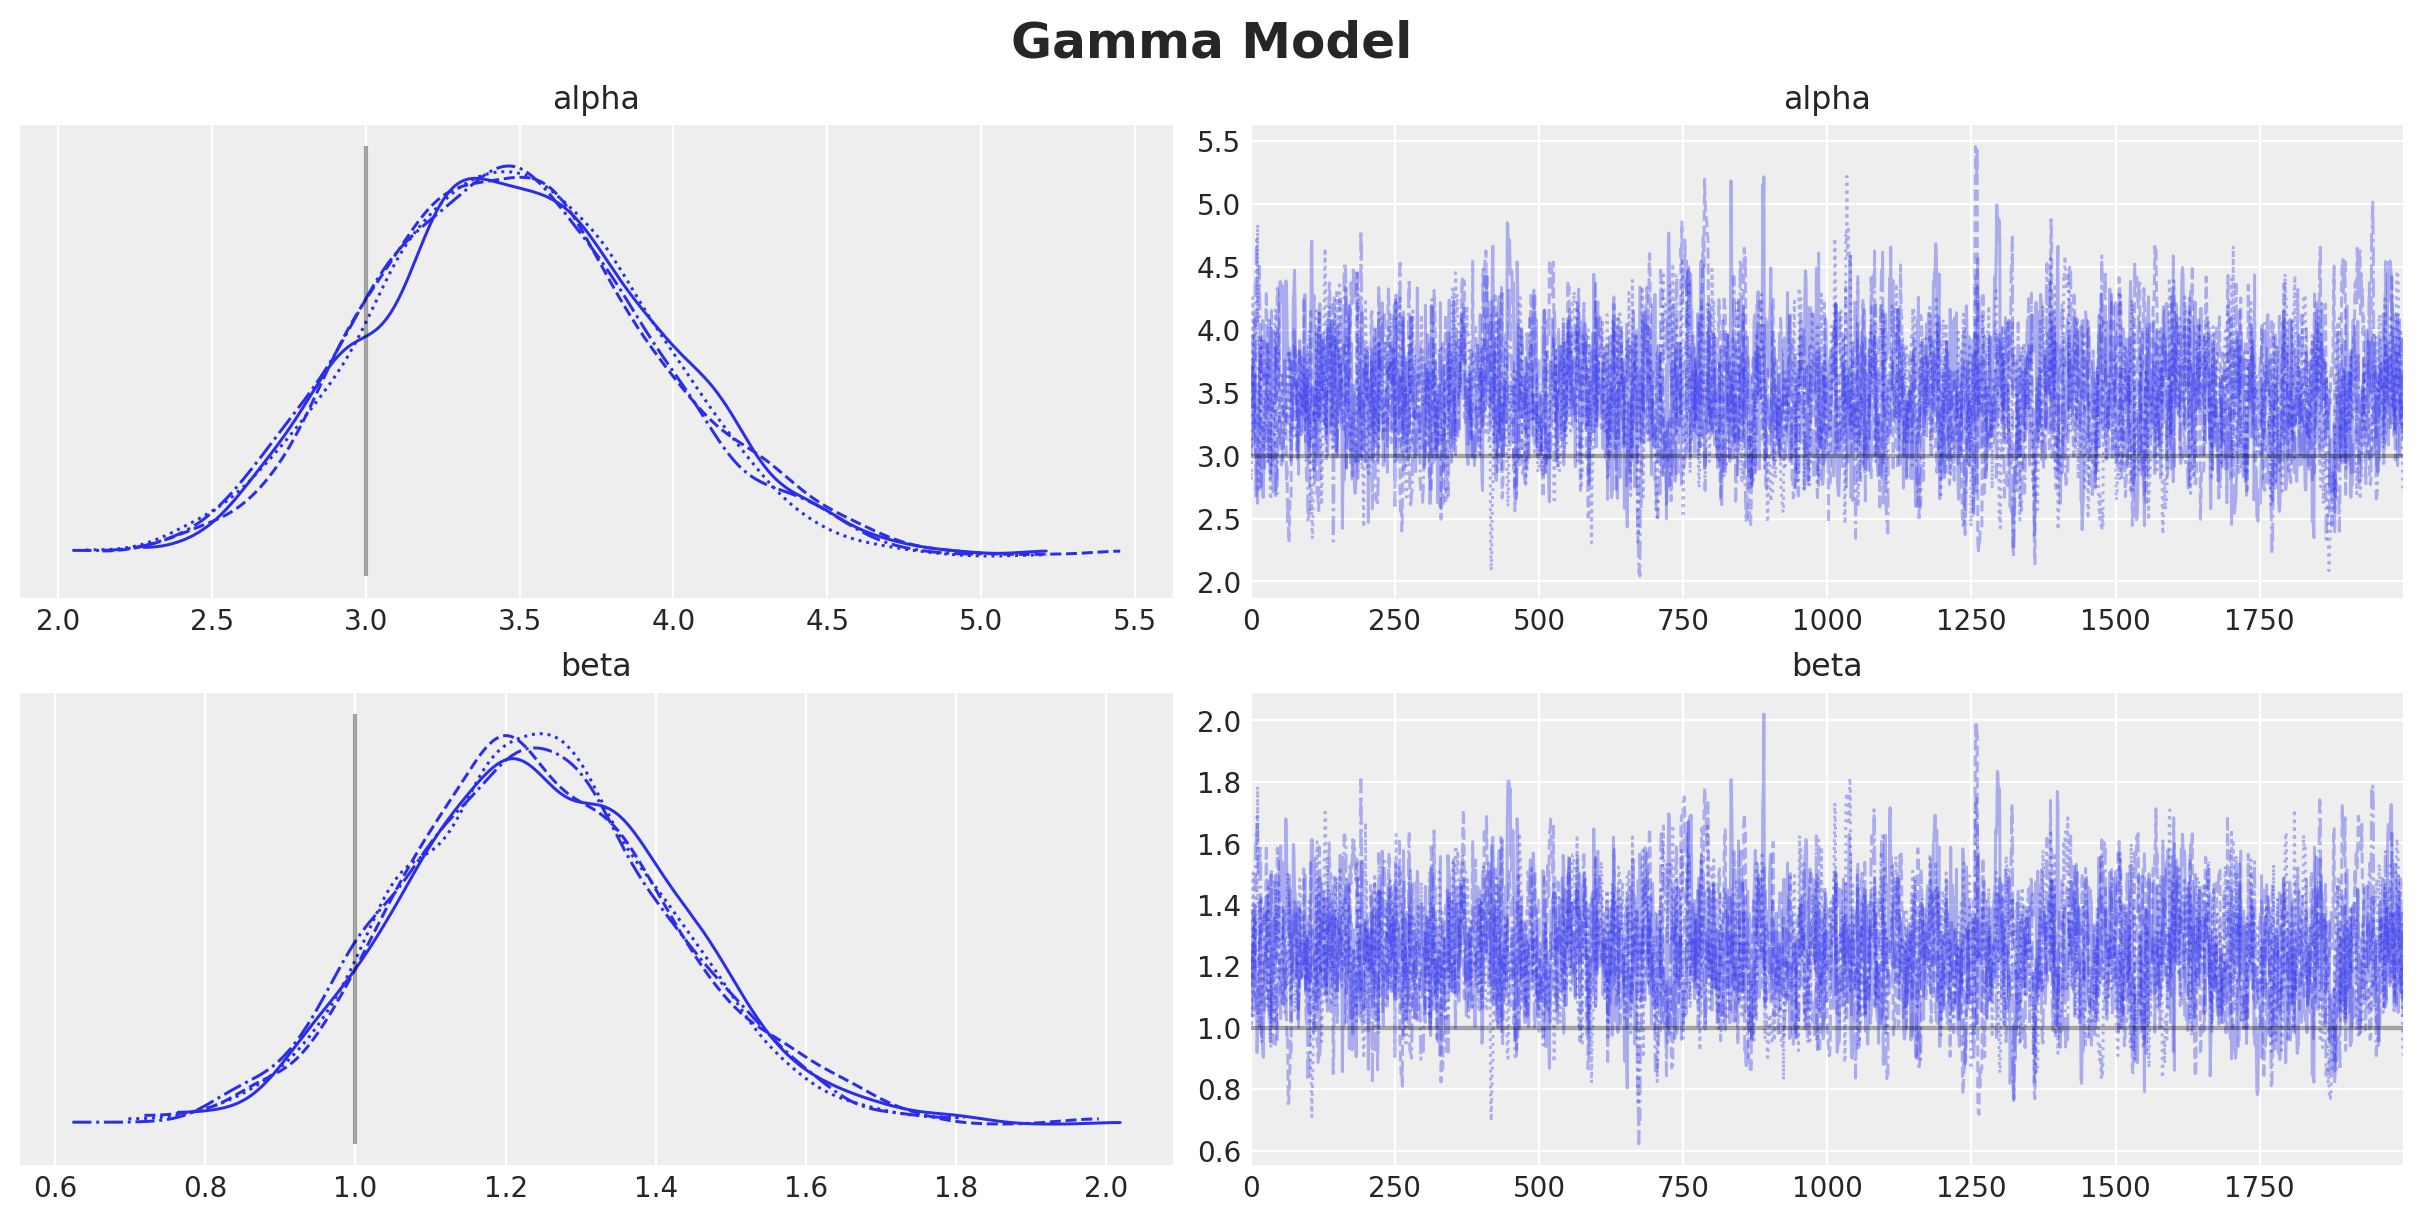

In [5]:
axes = az.plot_trace(
    data=gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, censored_gamma_data_params.alpha),
        ("beta", {}, censored_gamma_data_params.beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Model", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Gamma Model Parameters')

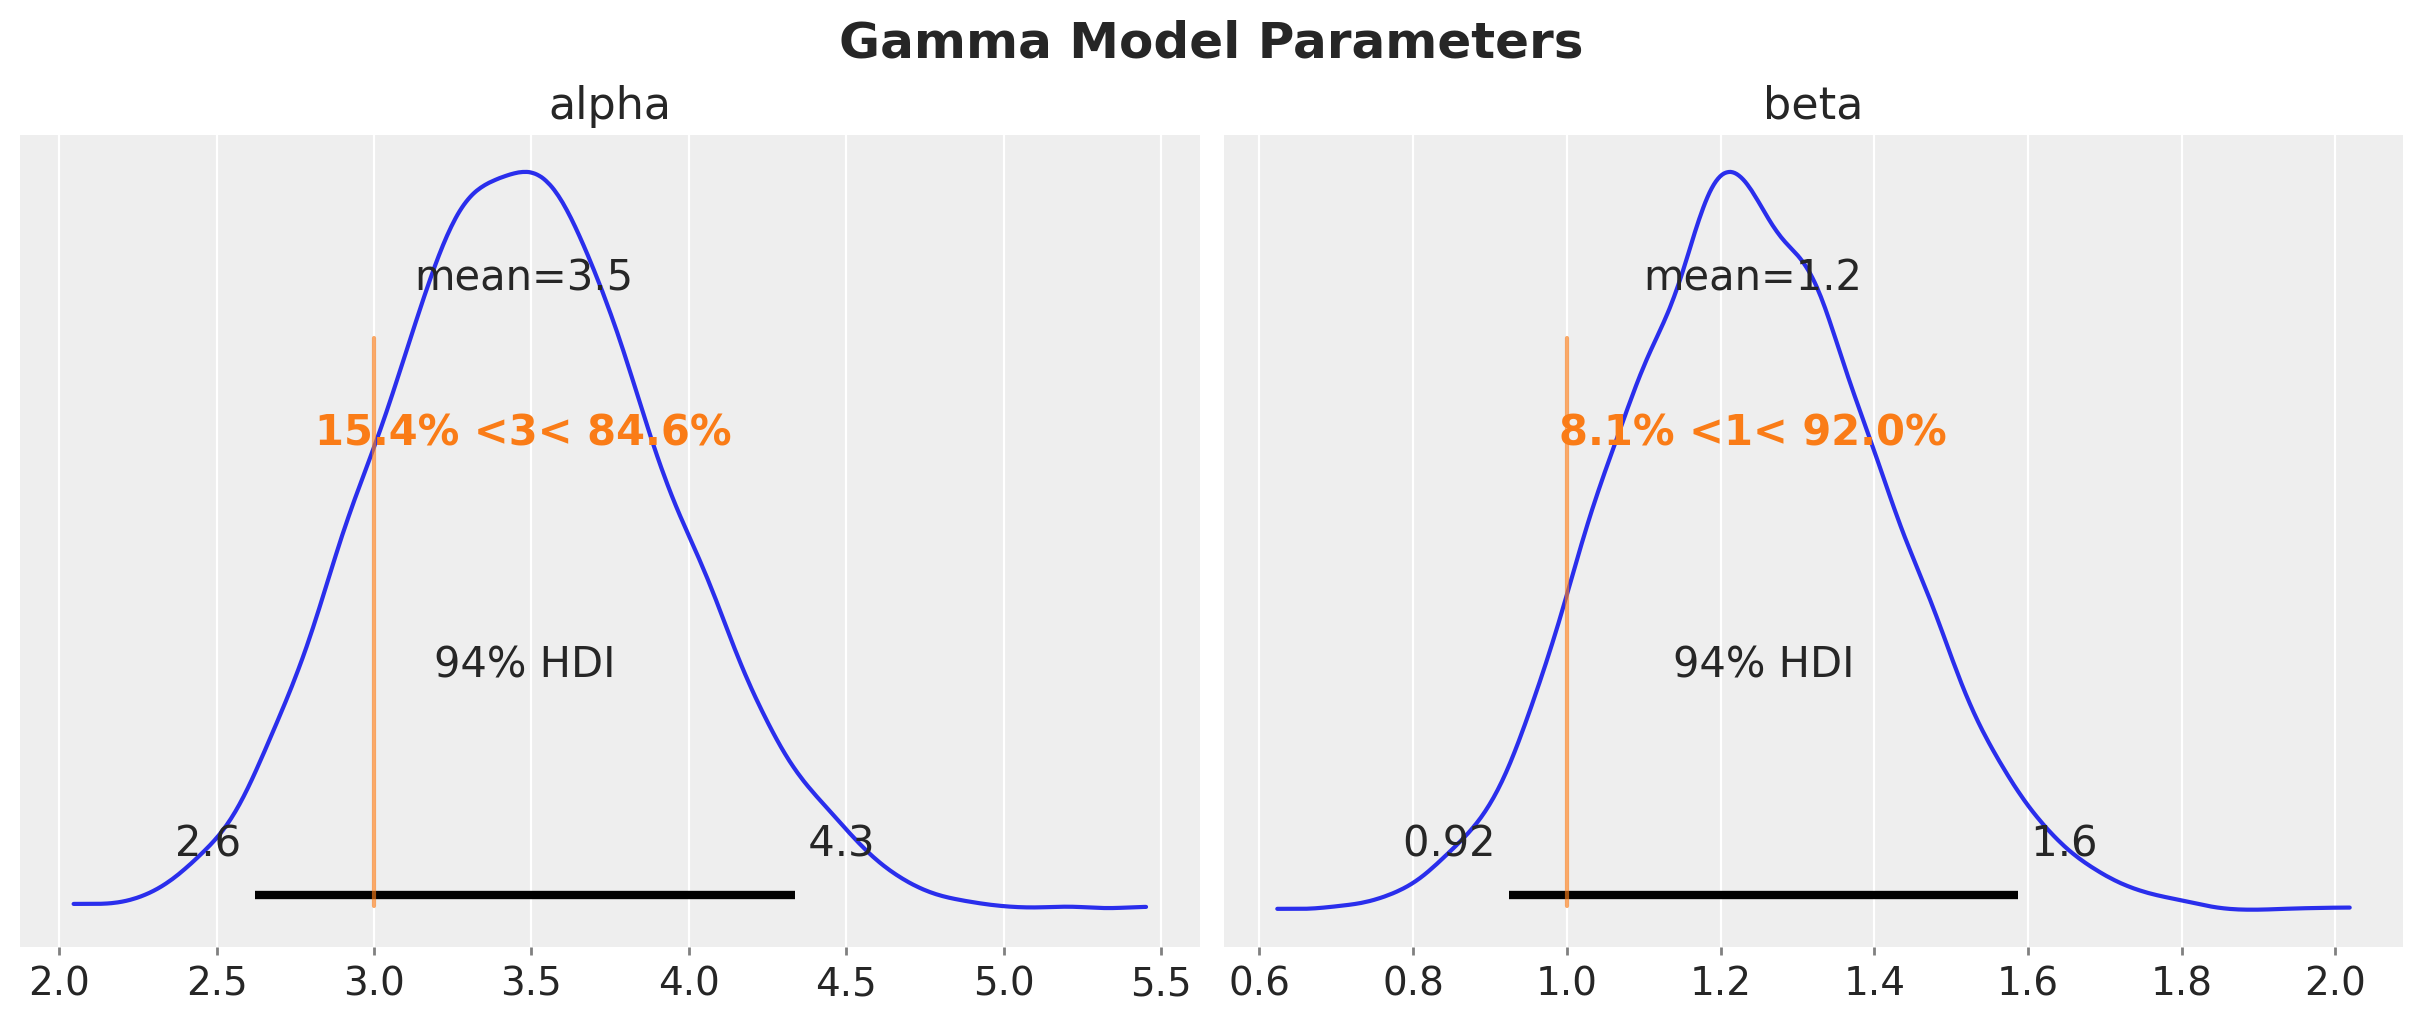

In [6]:
axes = az.plot_posterior(
    data=gamma_idata,
    ref_val=[censored_gamma_data_params.alpha, censored_gamma_data_params.beta],
    round_to=2,
    figsize=(12, 5),
)
plt.gcf().suptitle("Gamma Model Parameters", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Gamma Model')

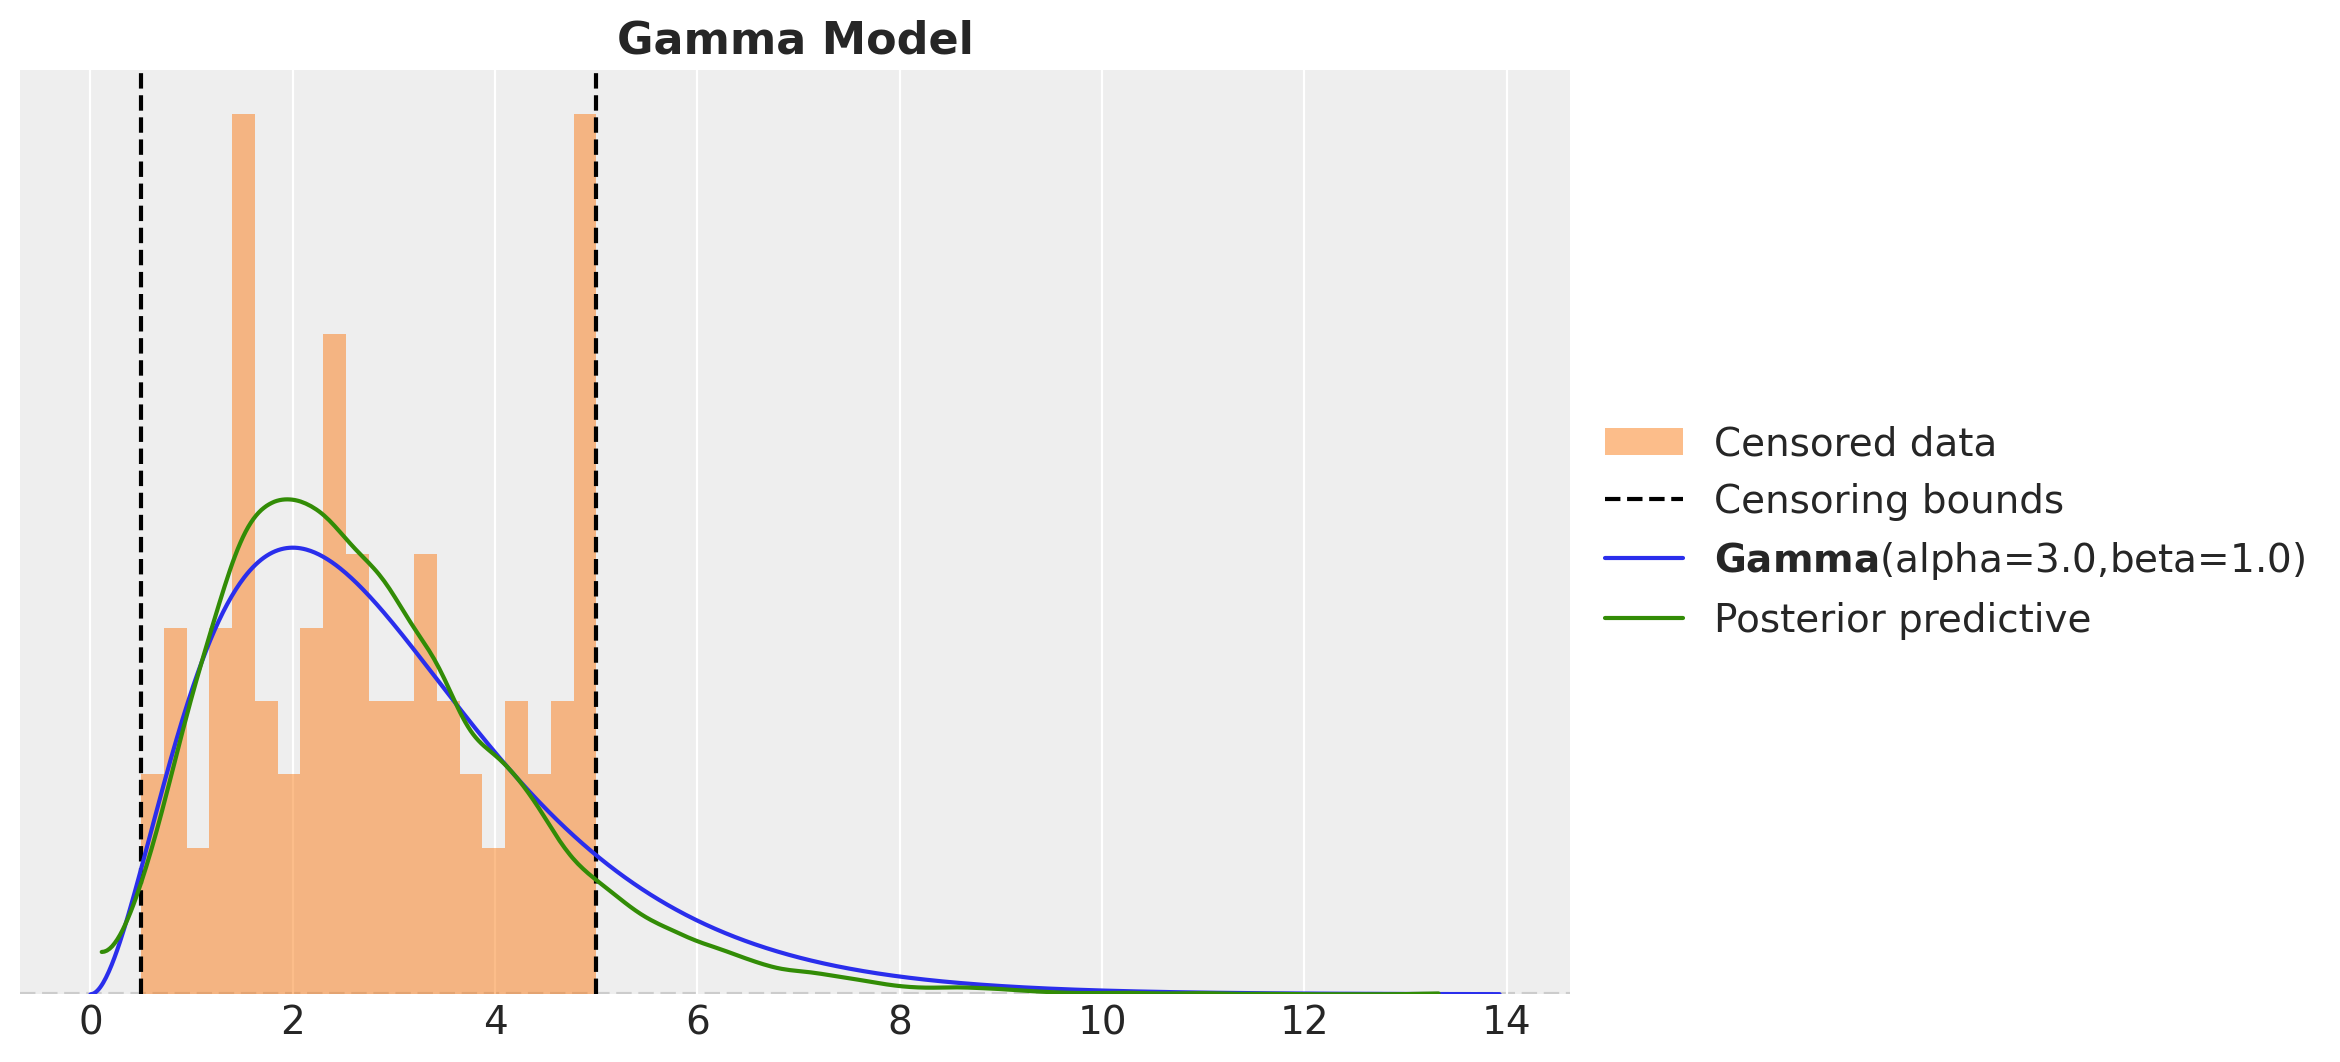

In [7]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Gamma Model", fontsize=16, fontweight="bold")

## Censored Gamma Model

In [8]:
def get_gamma_truncation_label(y: ArrayImpl, lower: float, upper: float) -> ArrayImpl:
    return jnp.where(
        y == lower,
        -1,
        jnp.where(y == upper, 1, 0),
    )


truncation_label = get_gamma_truncation_label(
    y=censored_gamma_samples,
    lower=censored_gamma_data_params.lower,
    upper=censored_gamma_data_params.upper,
)

In [9]:
def censored_gamma_model(
    y: ArrayImpl, lower: float, upper: float, truncation_label: ArrayImpl
) -> None:
    alpha = numpyro.sample("alpha", dist.Exponential(1.0))
    beta = numpyro.sample("beta", dist.Exponential(1.0))

    distribution = dist.Gamma(concentration=alpha, rate=beta)

    with mask(mask=truncation_label == -1):
        truncation_prob_lower = distribution.cdf(lower)
        numpyro.sample(
            "truncated_label_lower", dist.Bernoulli(truncation_prob_lower), obs=1
        )

    with mask(mask=truncation_label == 0):
        numpyro.sample("obs", distribution, obs=y)

    with mask(mask=truncation_label == 1):
        truncation_prob_upper = 1 - distribution.cdf(upper)
        numpyro.sample(
            "truncated_label_upper", dist.Bernoulli(truncation_prob_upper), obs=1
        )

In [10]:
censored_gamma_kernel = NUTS(censored_gamma_model)
censored_gamma_mcmc = MCMC(
    censored_gamma_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_mcmc.run(
    rng_key,
    y=censored_gamma_samples,
    lower=censored_gamma_data_params.lower,
    upper=censored_gamma_data_params.upper,
    truncation_label=truncation_label,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
censored_gamma_predictive = Predictive(
    model=censored_gamma_model,
    posterior_samples=censored_gamma_mcmc.get_samples(),
    return_sites=["obs"],
)
rng_key, rng_subkey = random.split(rng_key)
censored_gamma_posterior_predictive = censored_gamma_predictive(
    rng_subkey,
    y=None,
    lower=censored_gamma_data_params.lower,
    upper=censored_gamma_data_params.upper,
    truncation_label=truncation_label,
)

censored_gamma_idata = az.from_numpyro(posterior=censored_gamma_mcmc)
censored_gamma_idata.extend(
    az.from_numpyro(posterior_predictive=censored_gamma_posterior_predictive)
)

Text(0.5, 0.98, 'Censored Gamma Model')

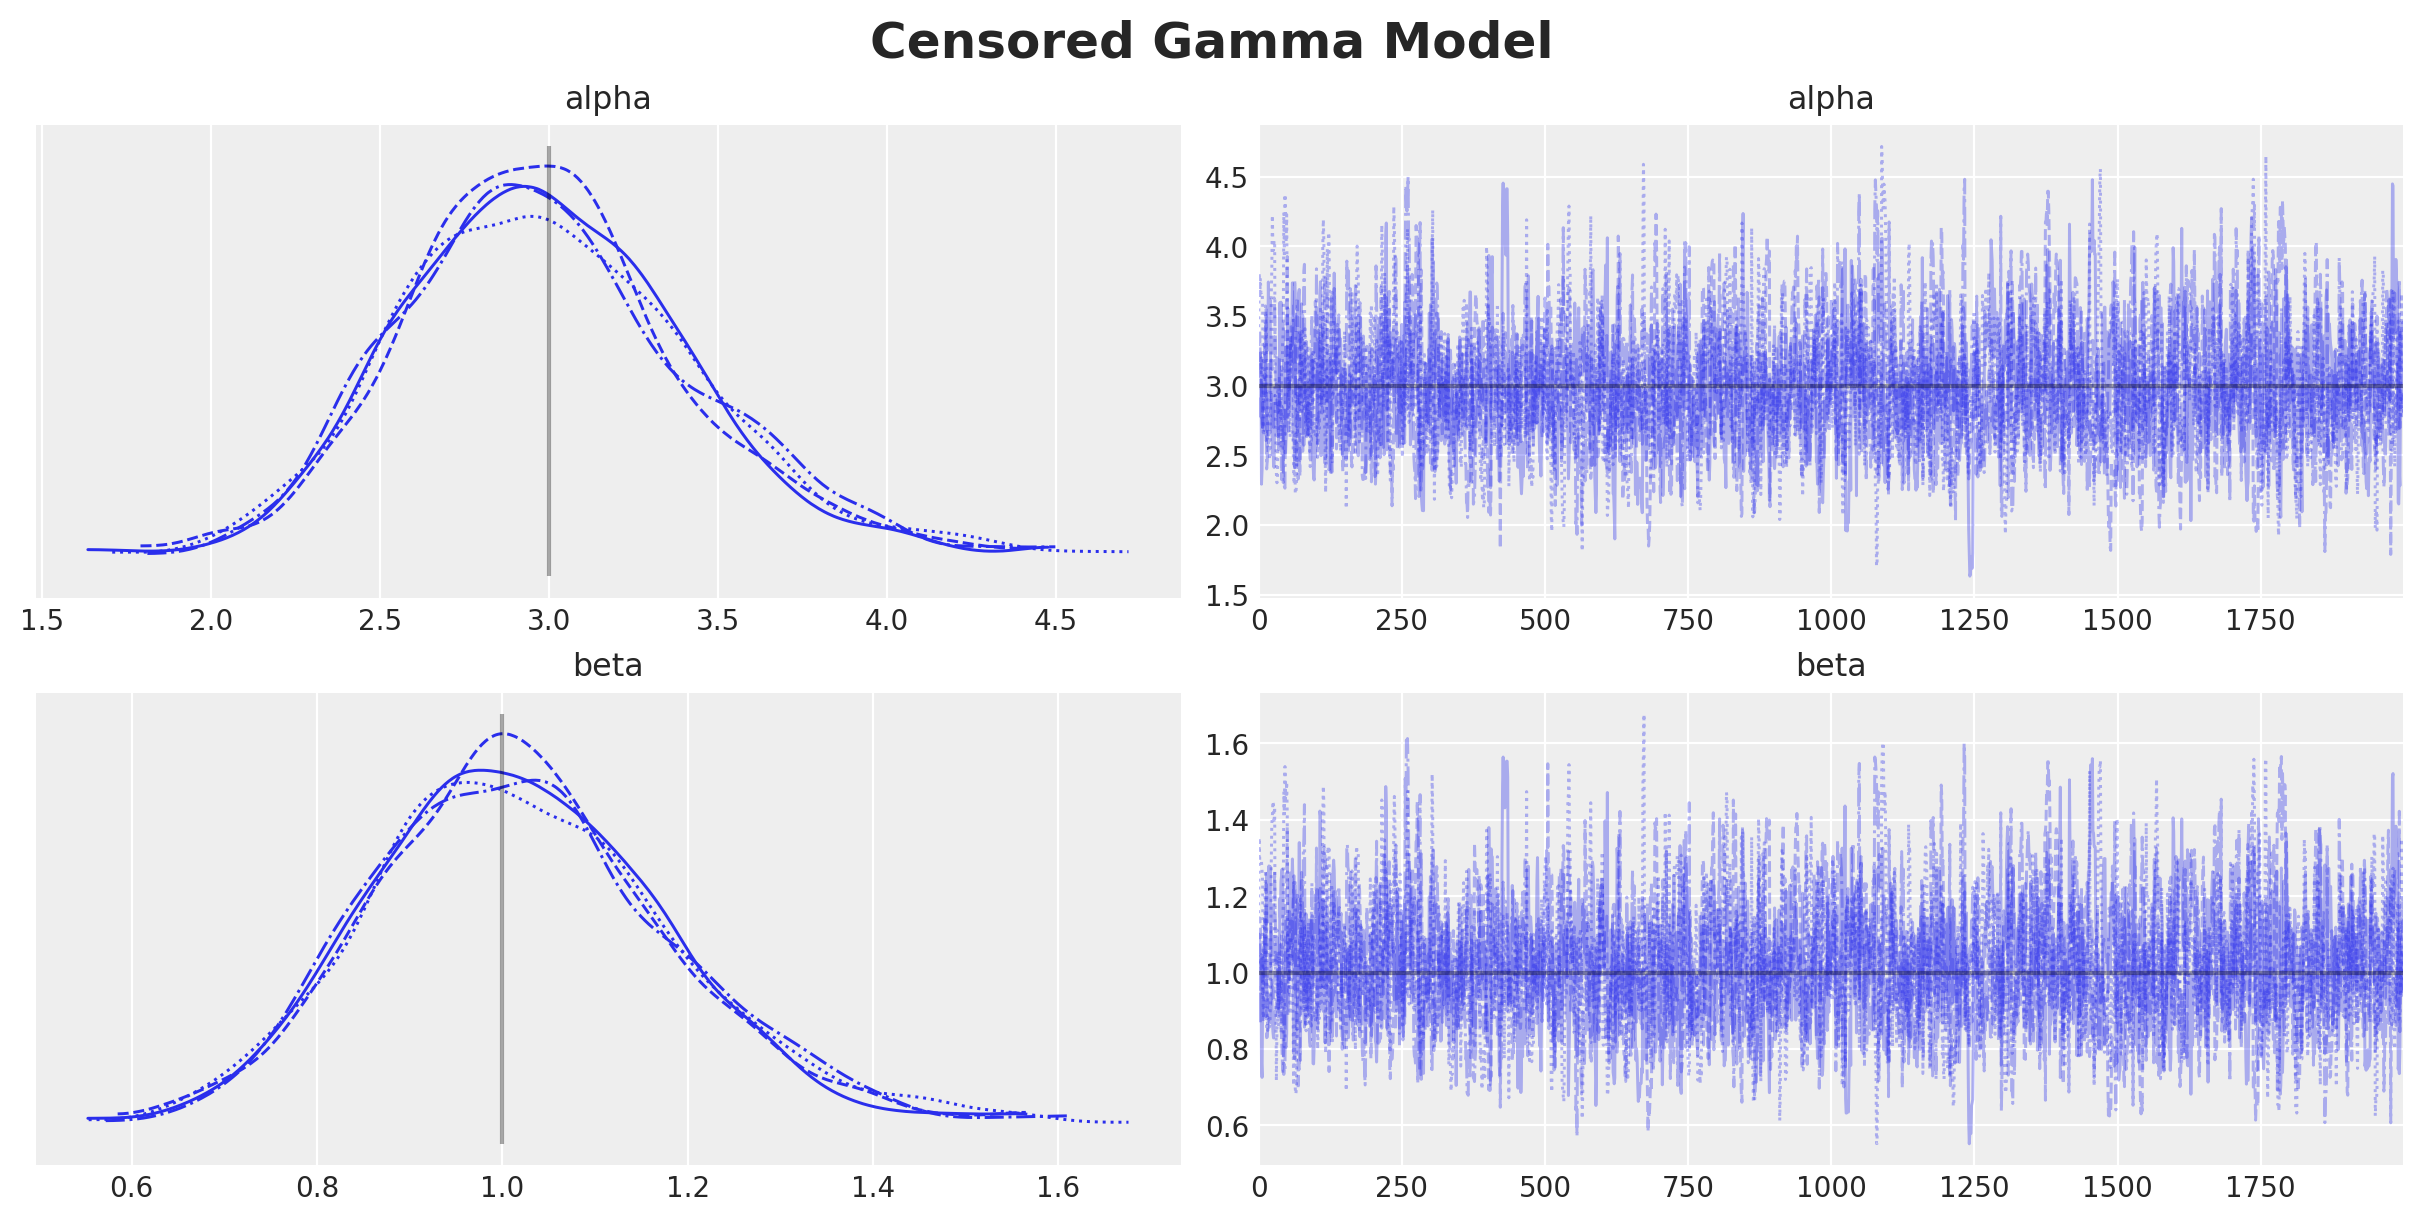

In [12]:
axes = az.plot_trace(
    data=censored_gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, censored_gamma_data_params.alpha),
        ("beta", {}, censored_gamma_data_params.beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Censored Gamma Model", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Censored Gamma Model Parameters')

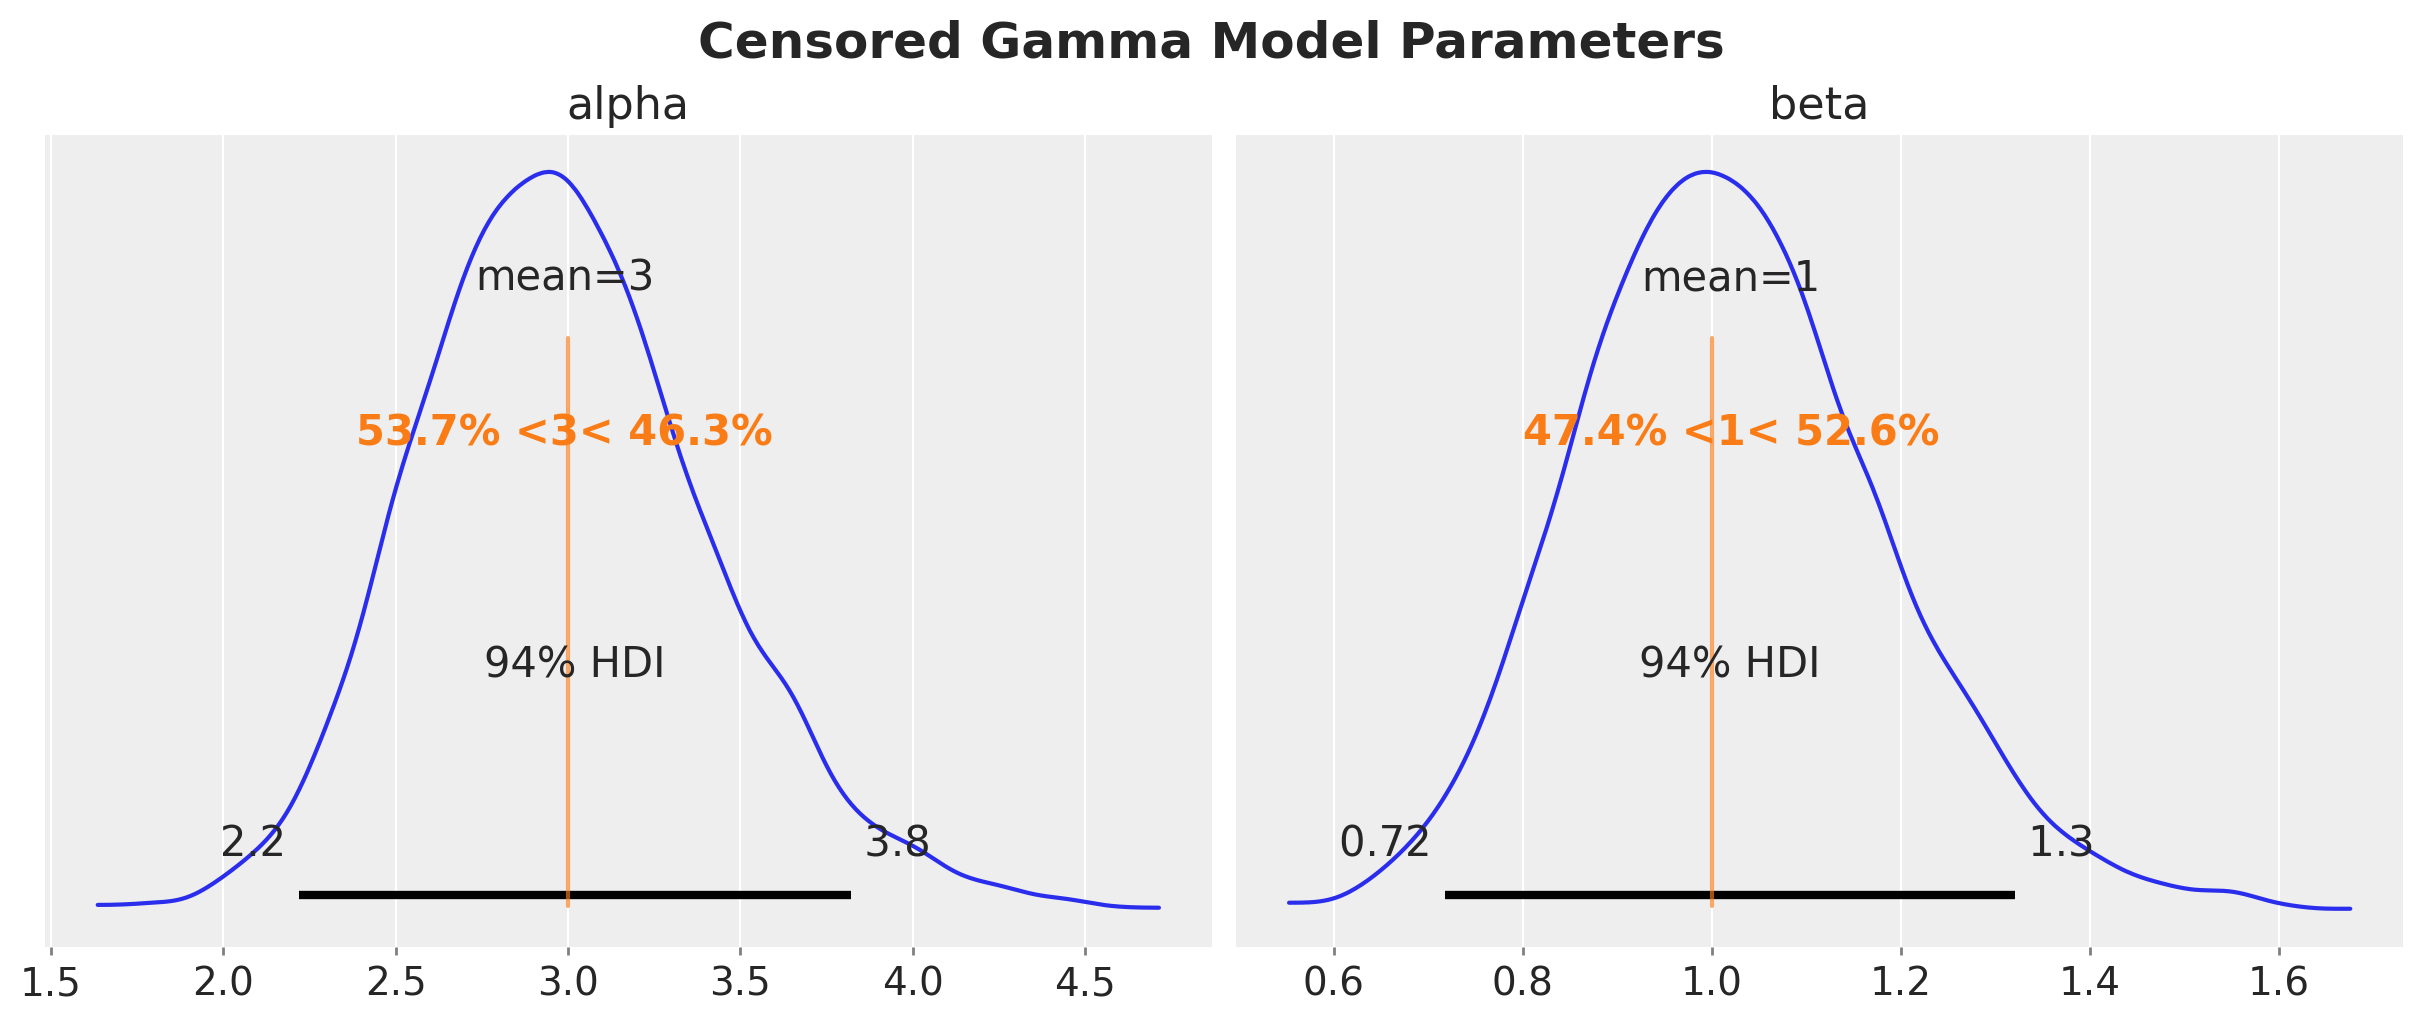

In [13]:
axes = az.plot_posterior(
    data=censored_gamma_idata,
    ref_val=[censored_gamma_data_params.alpha, censored_gamma_data_params.beta],
    round_to=2,
    figsize=(12, 5),
)
plt.gcf().suptitle("Censored Gamma Model Parameters", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Censored Gamma Model (no clipping)')

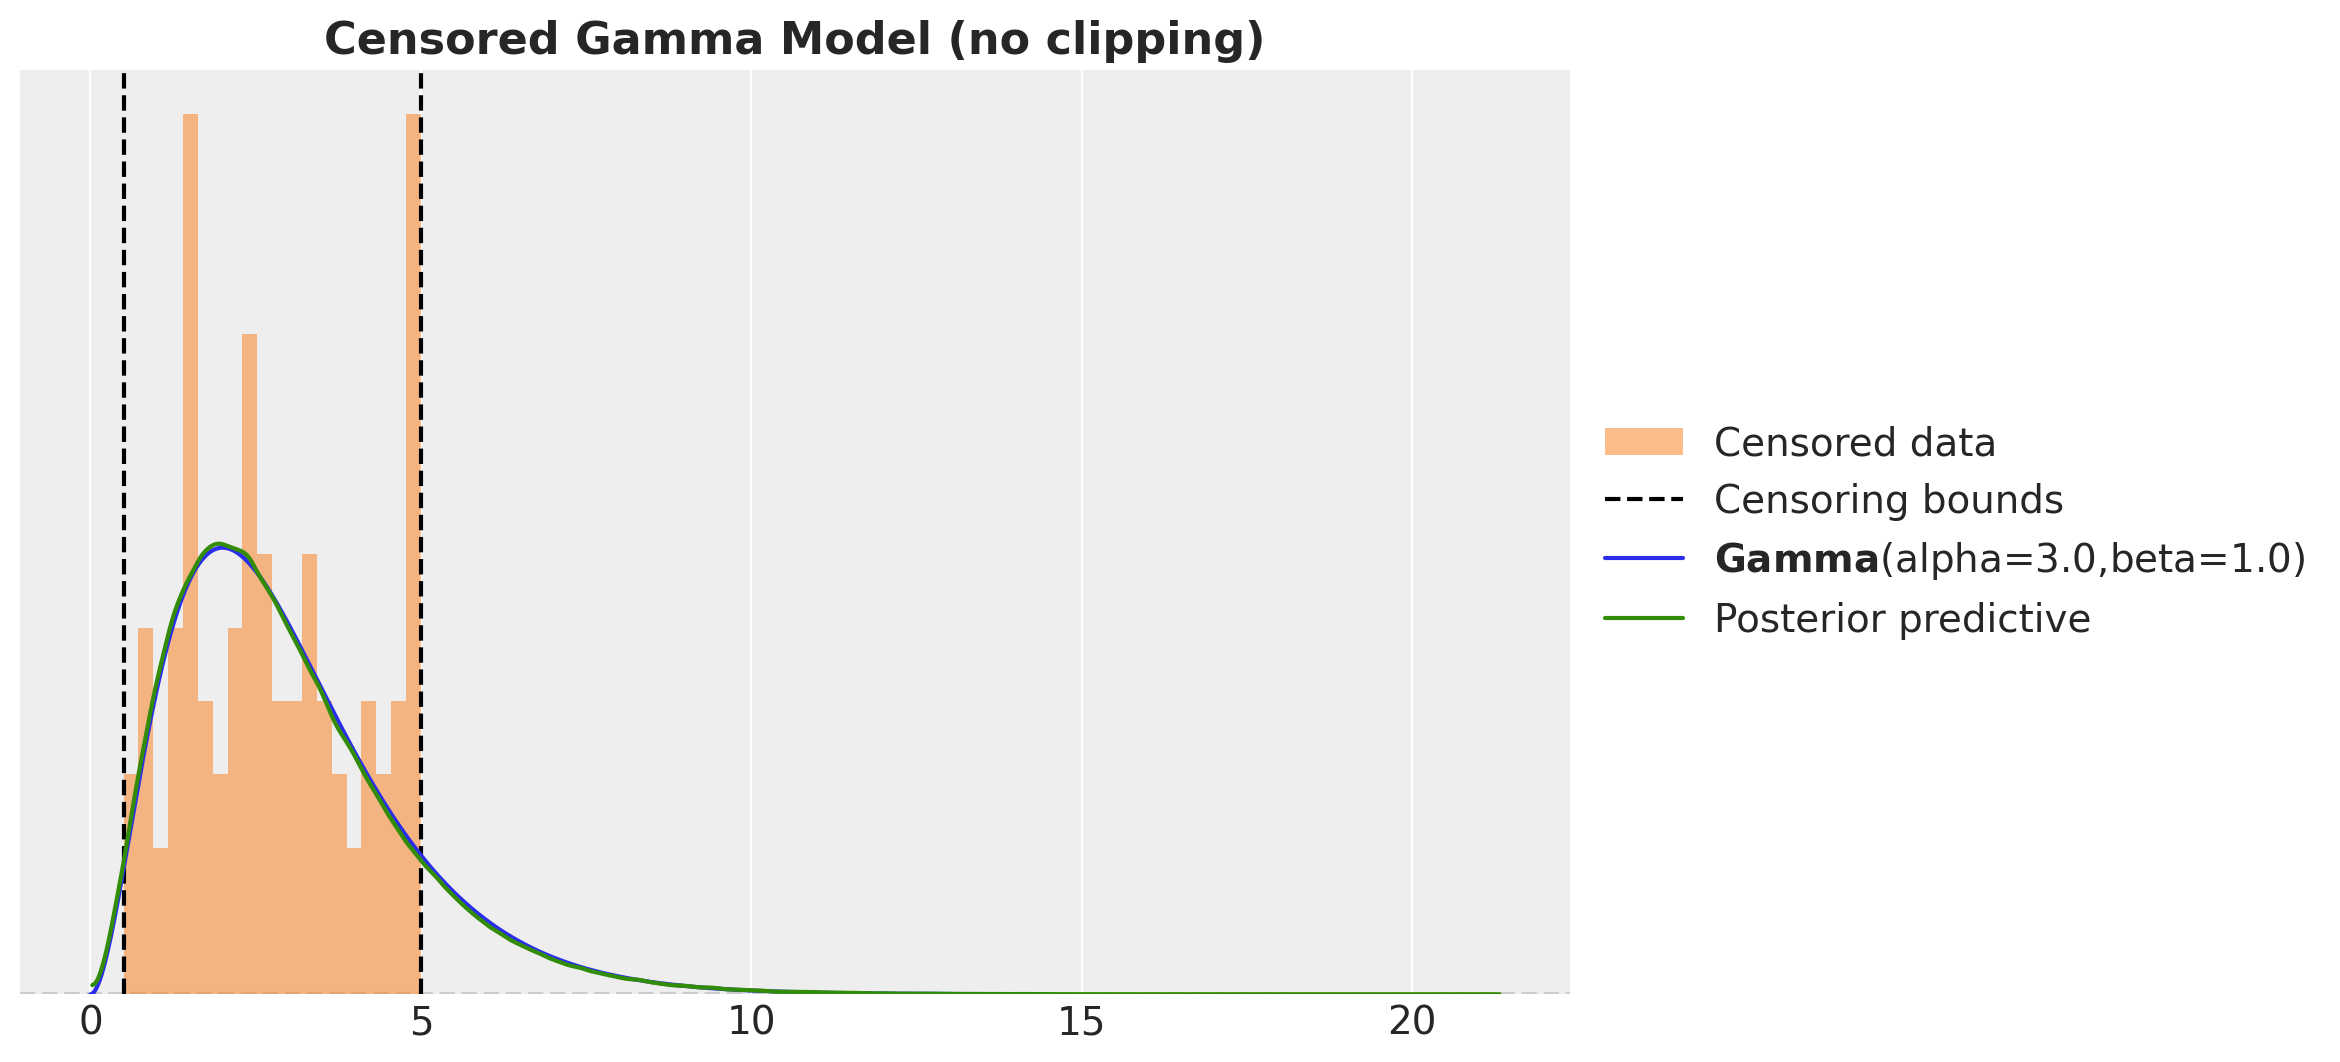

In [14]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    censored_gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma Model (no clipping)", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'Censored Gamma Model')

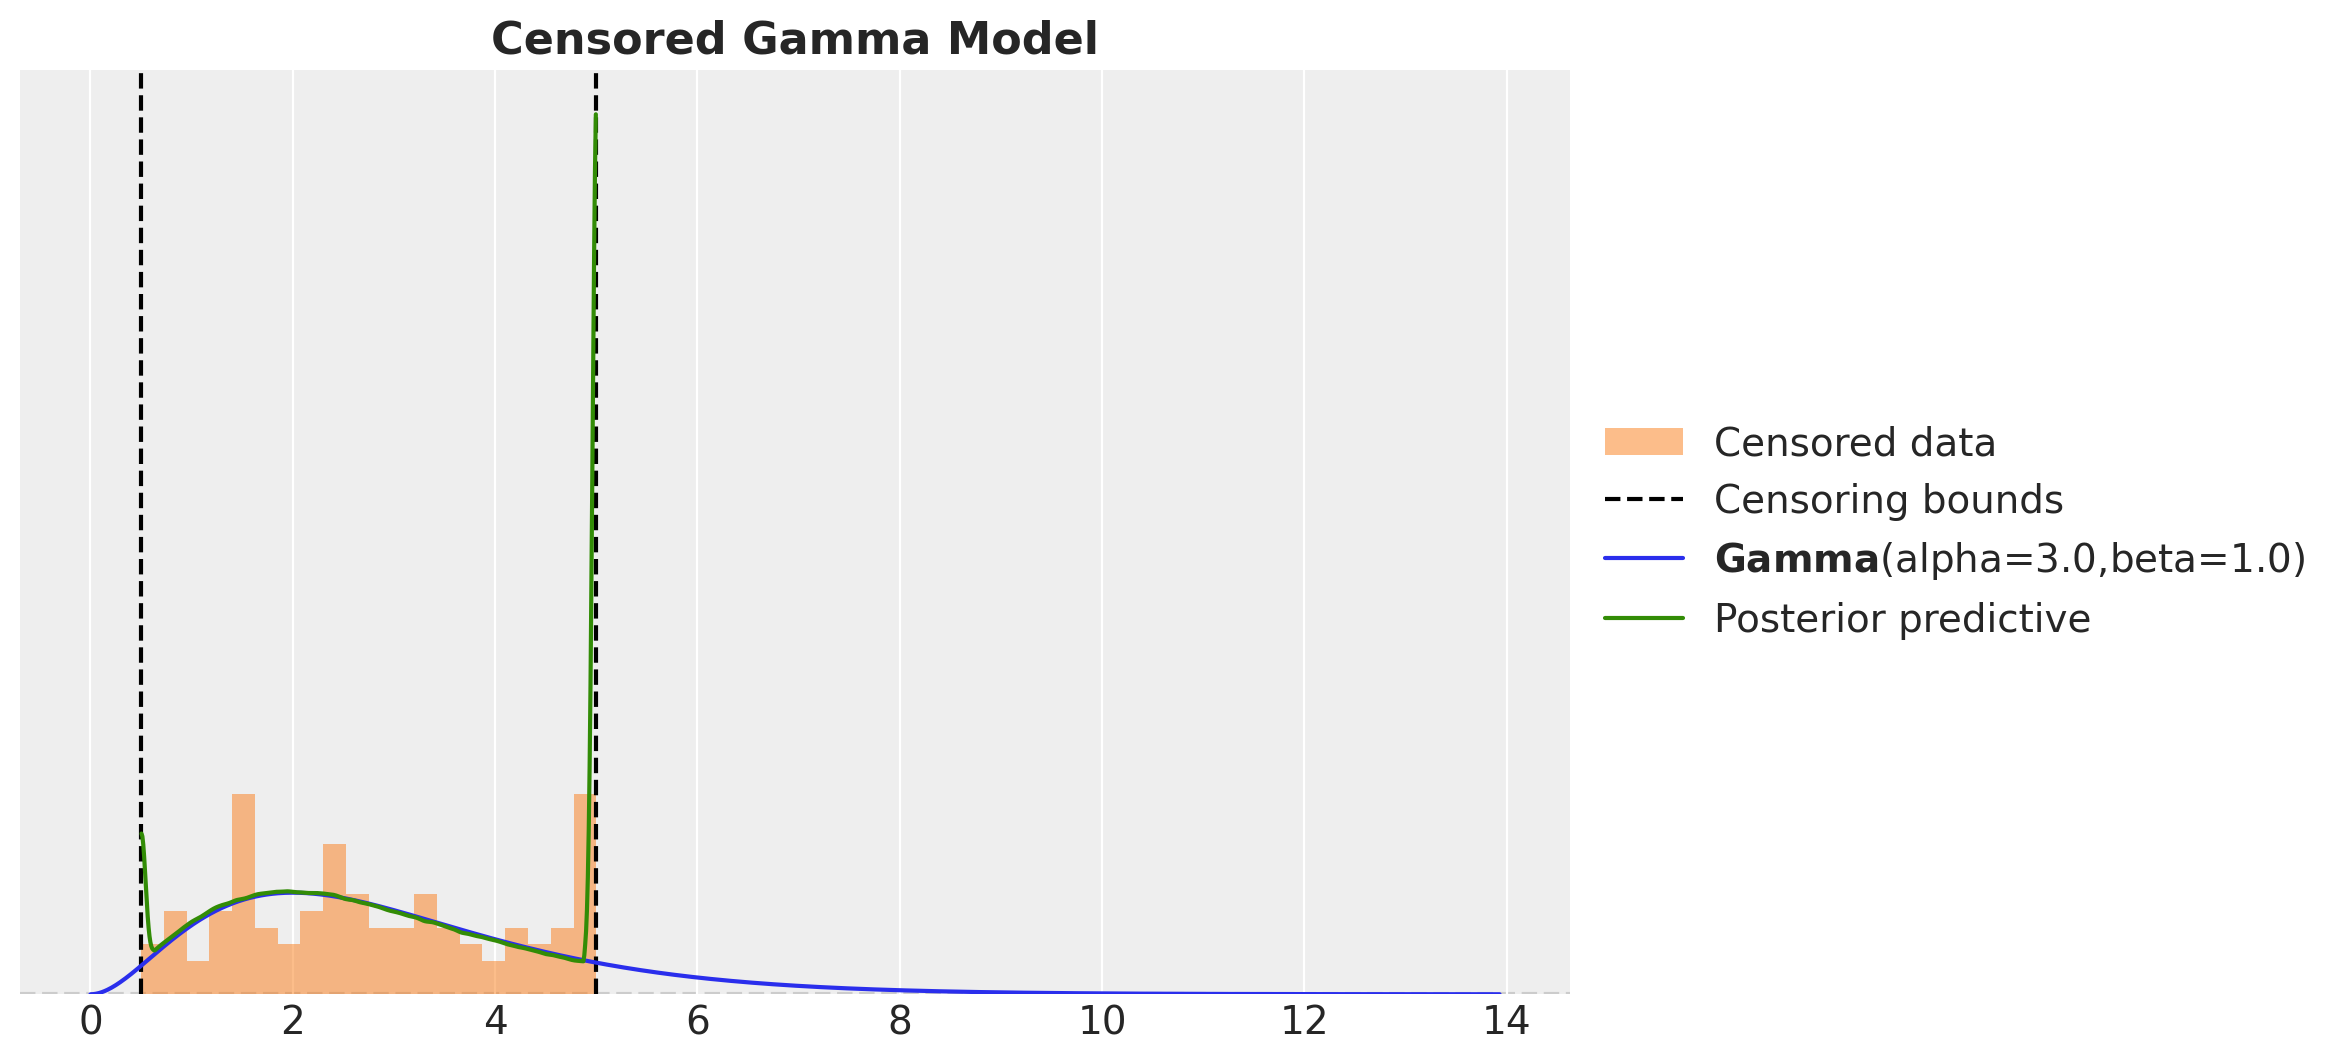

In [15]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    censored_gamma_idata["posterior_predictive"]["obs"]
    .clip(min=censored_gamma_data_params.lower, max=censored_gamma_data_params.upper)
    .to_numpy()
    .flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma Model", fontsize=16, fontweight="bold")

## Censored Gamma Model with PyMC

In [16]:
with pm.Model() as pymc_censored_gamma_model:
    alpha = pm.Exponential("alpha", lam=1.0)
    beta = pm.Exponential("beta", lam=1.0)

    distribution = pm.Gamma.dist(alpha=alpha, beta=beta)
    pm.Censored(
        "obs",
        dist=distribution,
        lower=censored_gamma_data_params.lower,
        upper=censored_gamma_data_params.upper,
        observed=censored_gamma_samples,
    )

In [17]:
rng_key, rng_subkey = random.split(rng_key)

with pymc_censored_gamma_model:
    pymc_censored_gamma_idata = pm.sample(
        tune=inference_params.num_warmup,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

    pymc_censored_gamma_idata.extend(
        pm.sample_posterior_predictive(trace=pymc_censored_gamma_idata)
    )

Compiling...
Compilation time = 0:00:01.939113
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time = 0:00:09.044245
Transforming variables...
Transformation time = 0:00:00.156393
Sampling: [obs]


Text(0.5, 0.98, 'PyMC Censored Gamma Model')

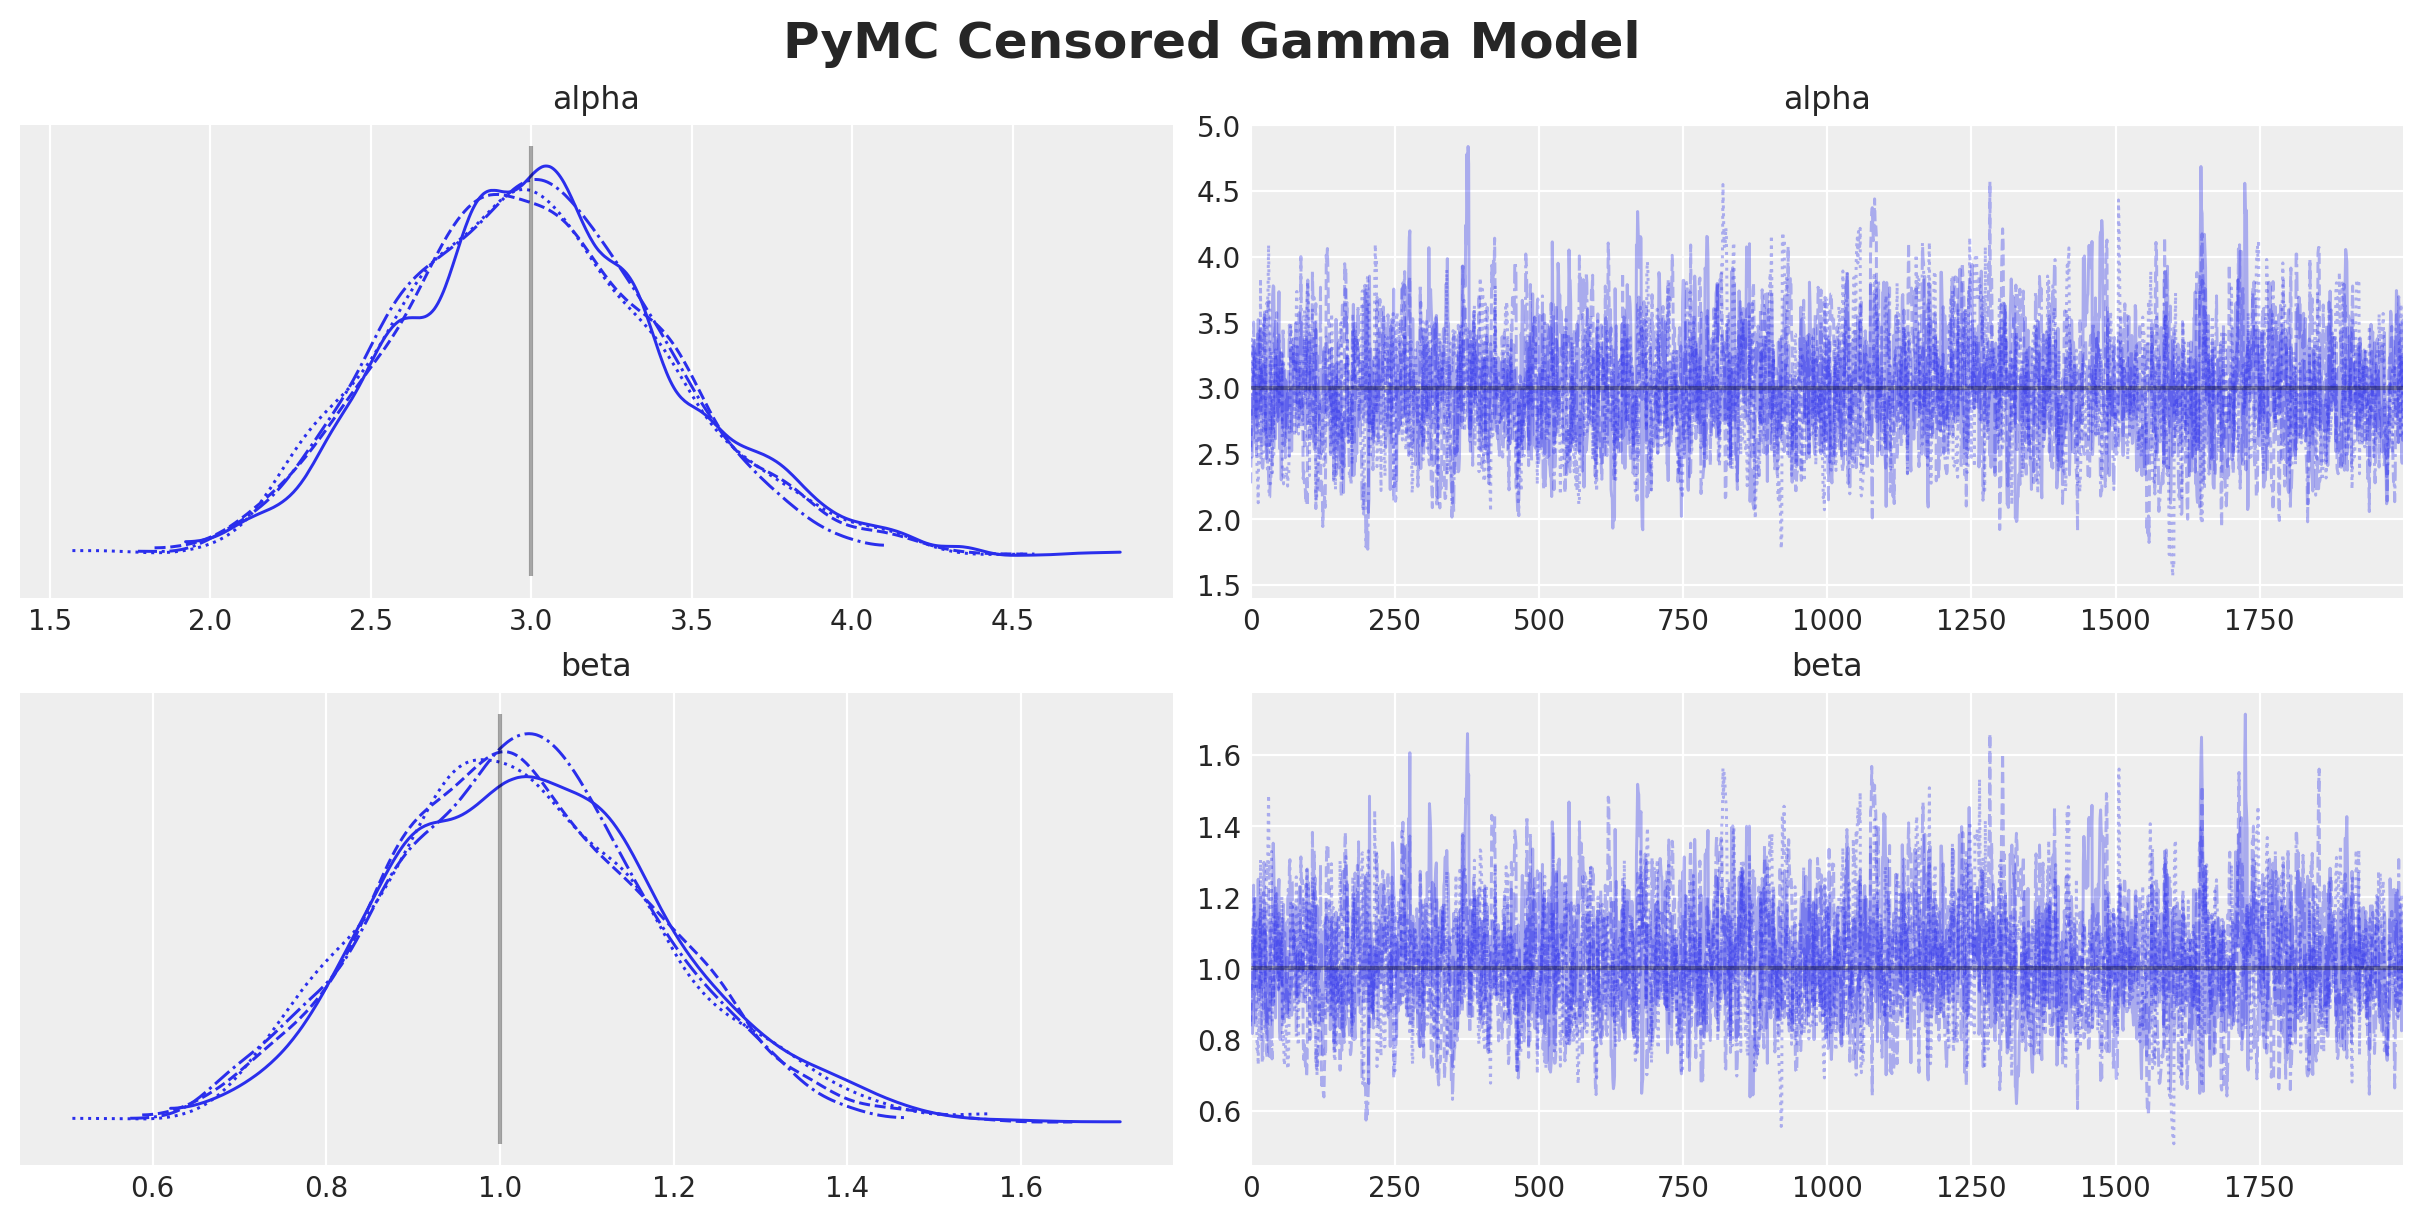

In [18]:
axes = az.plot_trace(
    data=pymc_censored_gamma_idata,
    compact=True,
    lines=[
        ("alpha", {}, censored_gamma_data_params.alpha),
        ("beta", {}, censored_gamma_data_params.beta),
    ],
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle("PyMC Censored Gamma Model", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Censored Gamma PyMC Model Parameters')

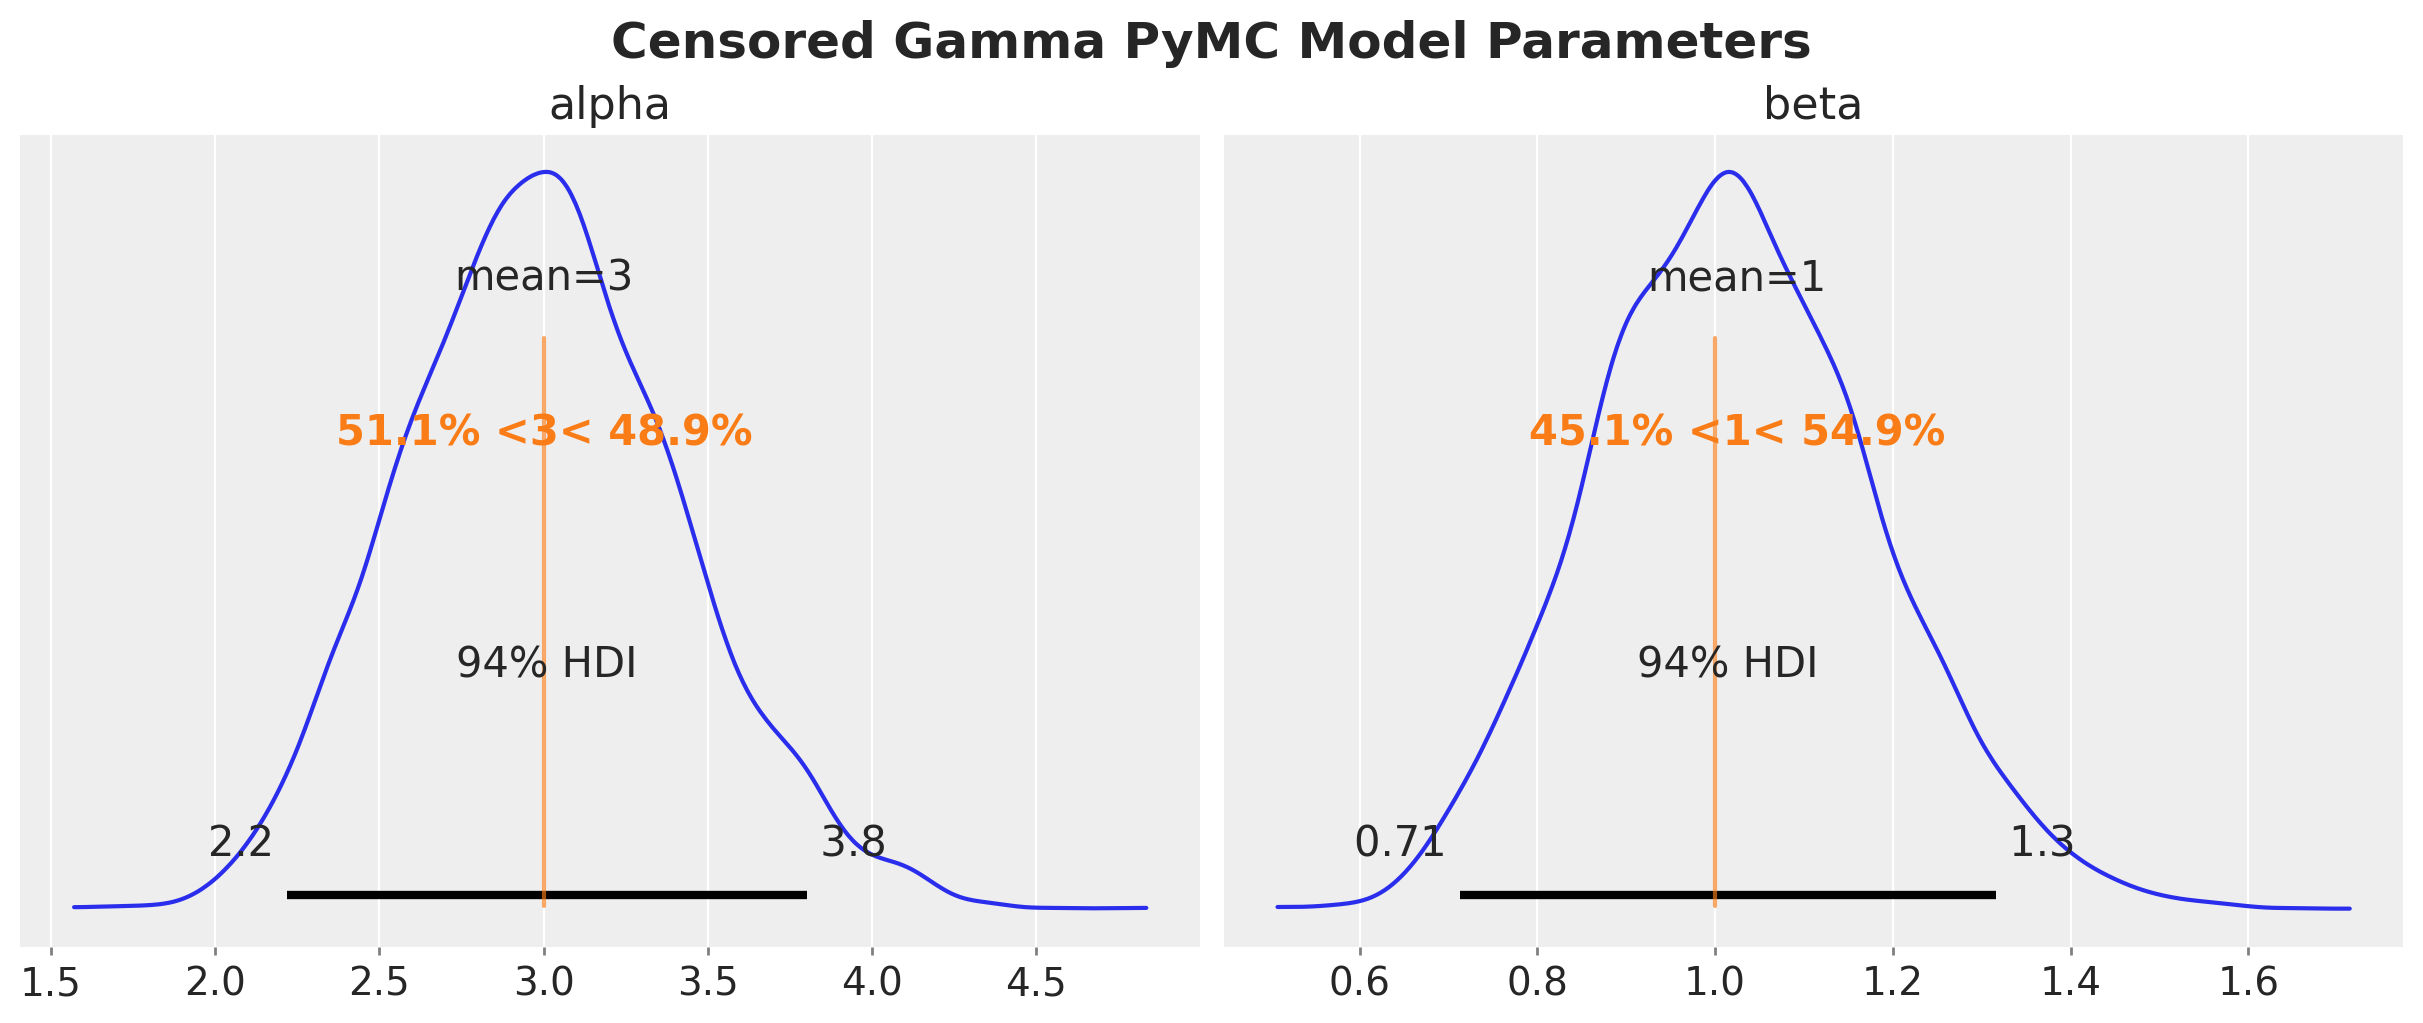

In [19]:
axes = az.plot_posterior(
    data=pymc_censored_gamma_idata,
    ref_val=[censored_gamma_data_params.alpha, censored_gamma_data_params.beta],
    round_to=2,
    figsize=(12, 5),
)
plt.gcf().suptitle(
    "Censored Gamma PyMC Model Parameters", fontsize=18, fontweight="bold"
)

Text(0.5, 1.0, 'Censored Gamma PyMC Model')

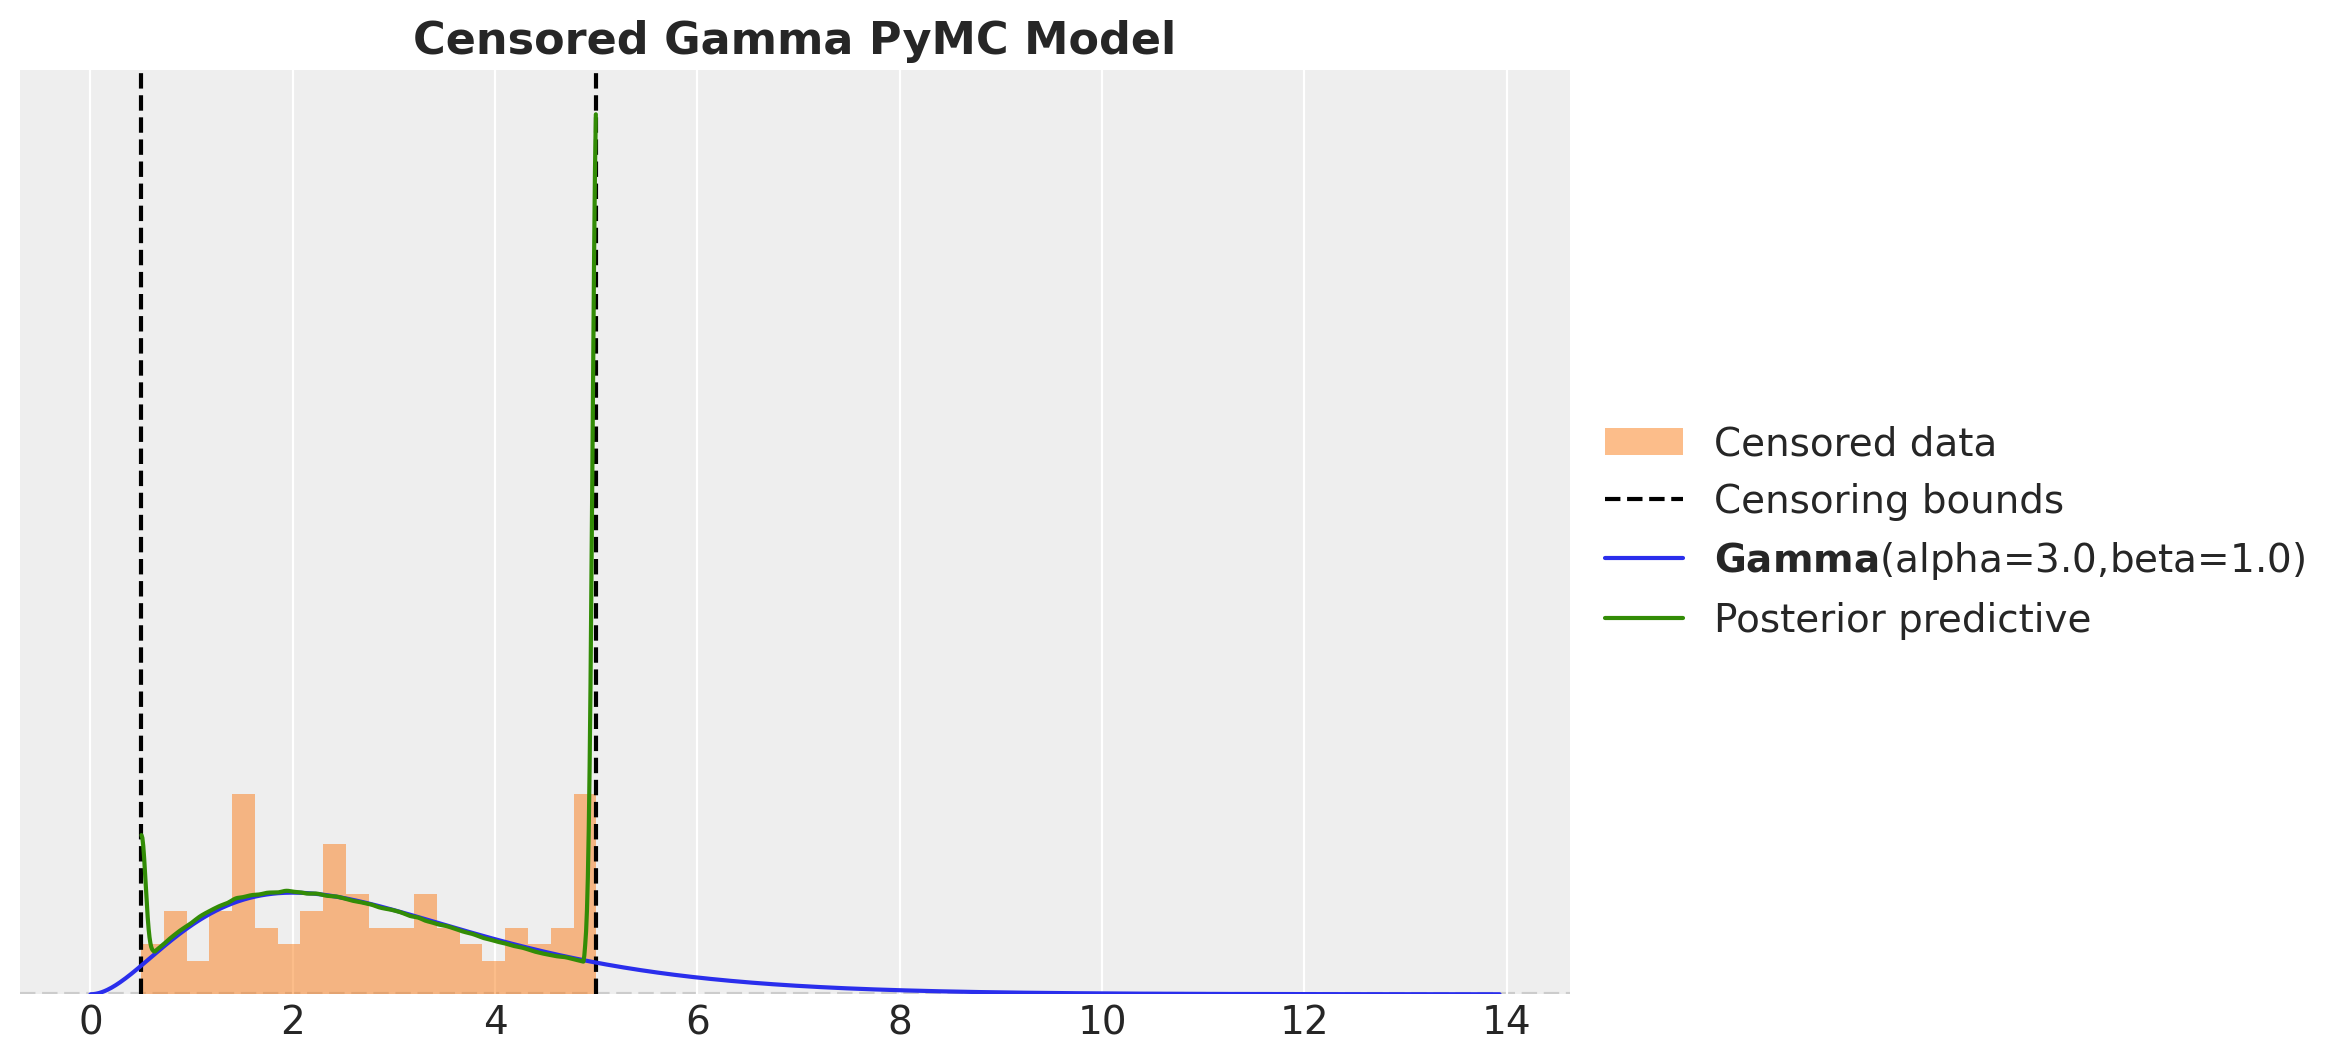

In [20]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_gamma_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_gamma_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Gamma(
    alpha=censored_gamma_data_params.alpha, beta=censored_gamma_data_params.beta
).plot_pdf(color="C0", ax=ax)
az.plot_kde(
    pymc_censored_gamma_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    plot_kwargs={"color": "C2", "label": "Posterior predictive"},
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Gamma PyMC Model", fontsize=16, fontweight="bold")

---

# Part II: Discrete Distribution

Text(0.5, 1.0, 'Censored Poisson Sample Data')

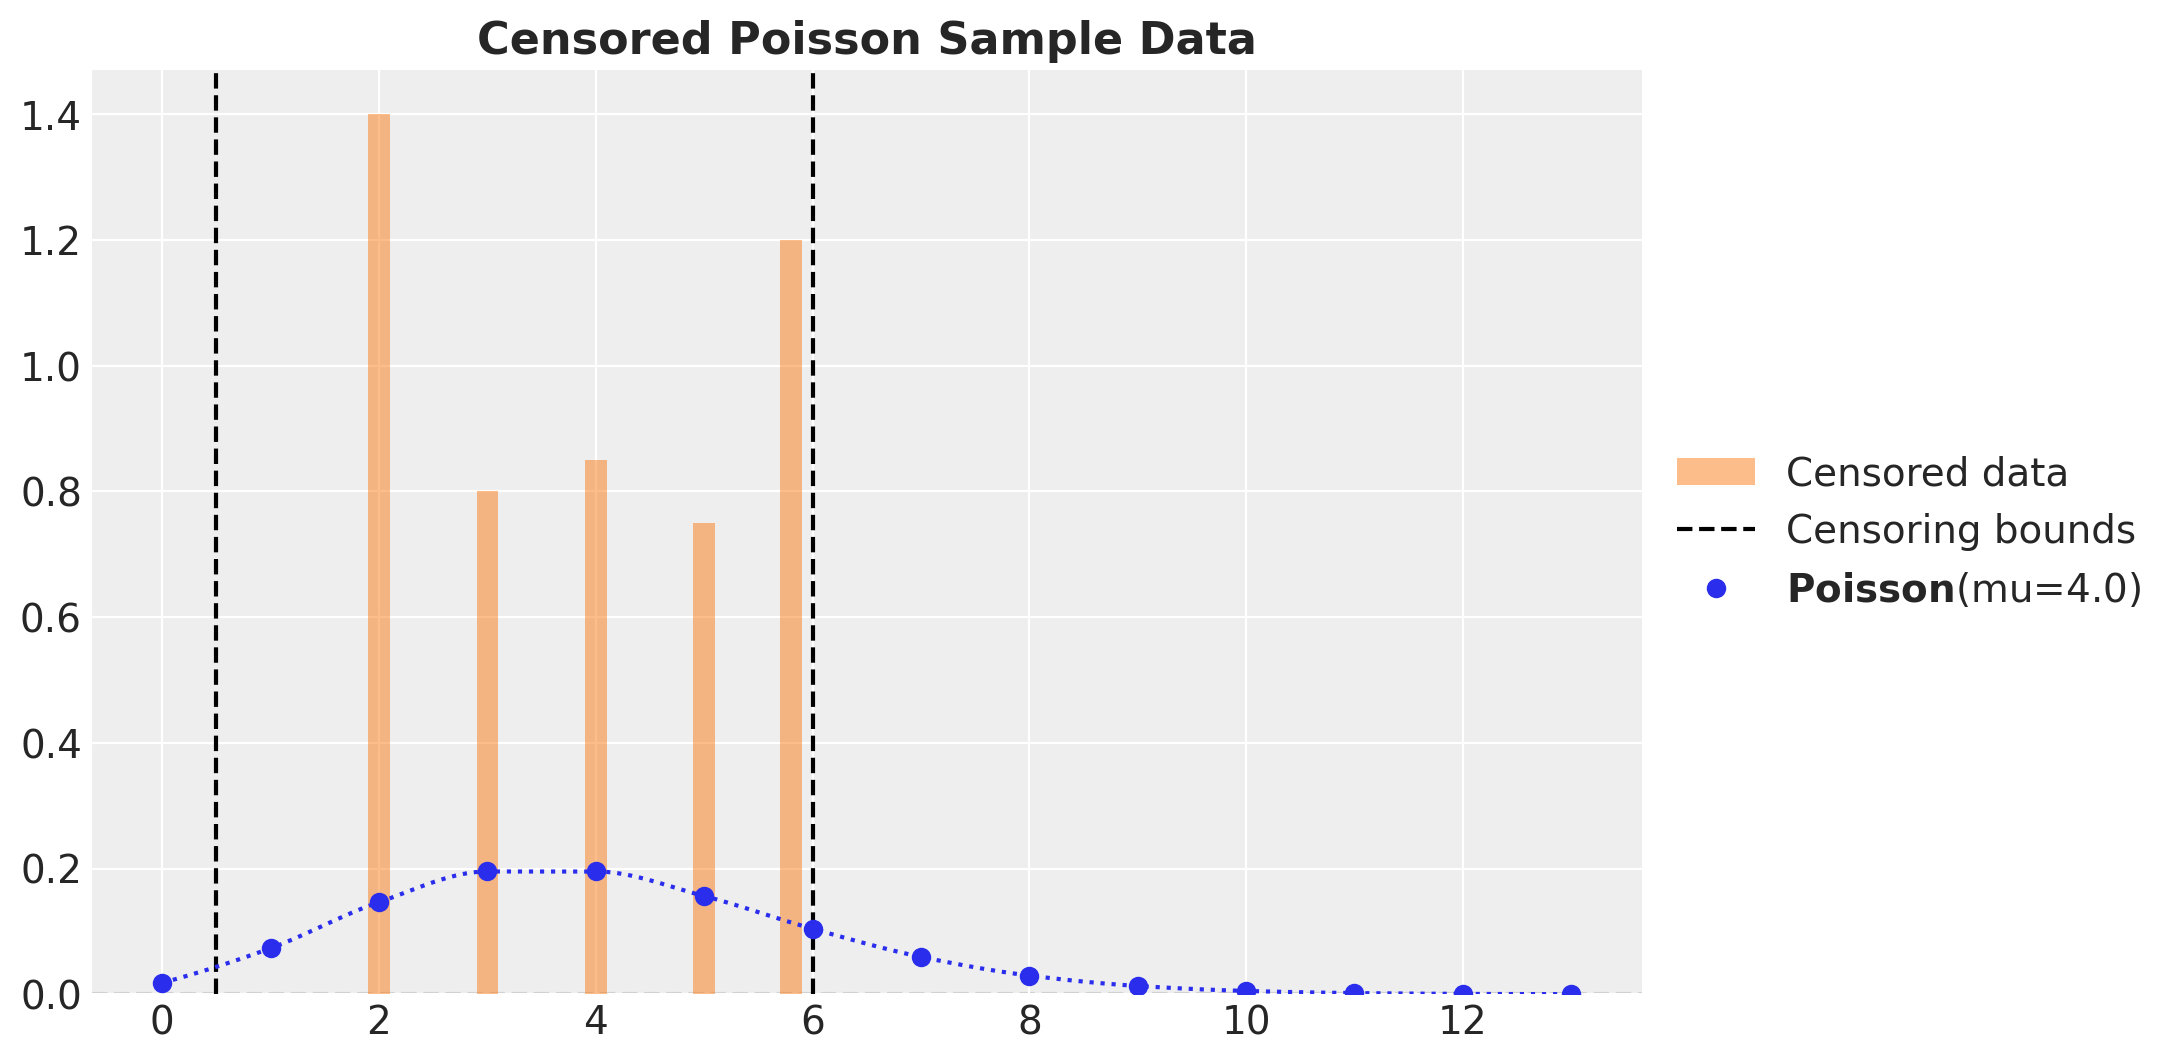

In [135]:
class CensoredPoissonDataParams(BaseModel):
    rate: float = Field(..., description="Rate parameter", gt=0)
    lower: float = Field(..., description="Lower censoring bound", gt=0)
    upper: float = Field(..., description="Upper censoring bound", gt=0)
    n: int = Field(..., description="Number of samples", gt=0)


def generate_censored_poisson_samples(
    rng_key: ArrayImpl, params: CensoredGammaDataParams
) -> ArrayImpl:
    raw_samples = dist.Poisson(rate=params.rate).sample(rng_key, (params.n,))
    return jnp.clip(raw_samples, params.lower, params.upper)


censored_poisson_data_params = CensoredPoissonDataParams(
    rate=4, lower=2, upper=6, n=100
)
rng_key, rng_subkey = random.split(rng_key)
censored_poisson_samples = generate_censored_poisson_samples(
    rng_key=rng_subkey, params=censored_poisson_data_params
)

fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    color="C1",
    alpha=0.5,
    label="Censored data",
    align="left",
)
ax.axvline(censored_gamma_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
ax.set_title("Censored Poisson Sample Data", fontsize=16, fontweight="bold")

## Naive Model

In [136]:
def poisson_model(y: ArrayImpl) -> None:
    rate = numpyro.sample("rate", dist.Exponential(1.0))
    numpyro.sample("obs", dist.Poisson(rate), obs=y)


poisson_kernel = NUTS(poisson_model)
poisson_mcmc = MCMC(
    poisson_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
poisson_mcmc.run(rng_key, y=censored_poisson_samples)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [137]:
poisson_predictive = Predictive(
    model=poisson_model, posterior_samples=poisson_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
poisson_posterior_predictive = poisson_predictive(rng_subkey, y=None)

poisson_idata = az.from_numpyro(posterior=poisson_mcmc)
poisson_idata.extend(az.from_numpyro(posterior_predictive=poisson_posterior_predictive))

Text(0.5, 0.98, 'Poisson Model')

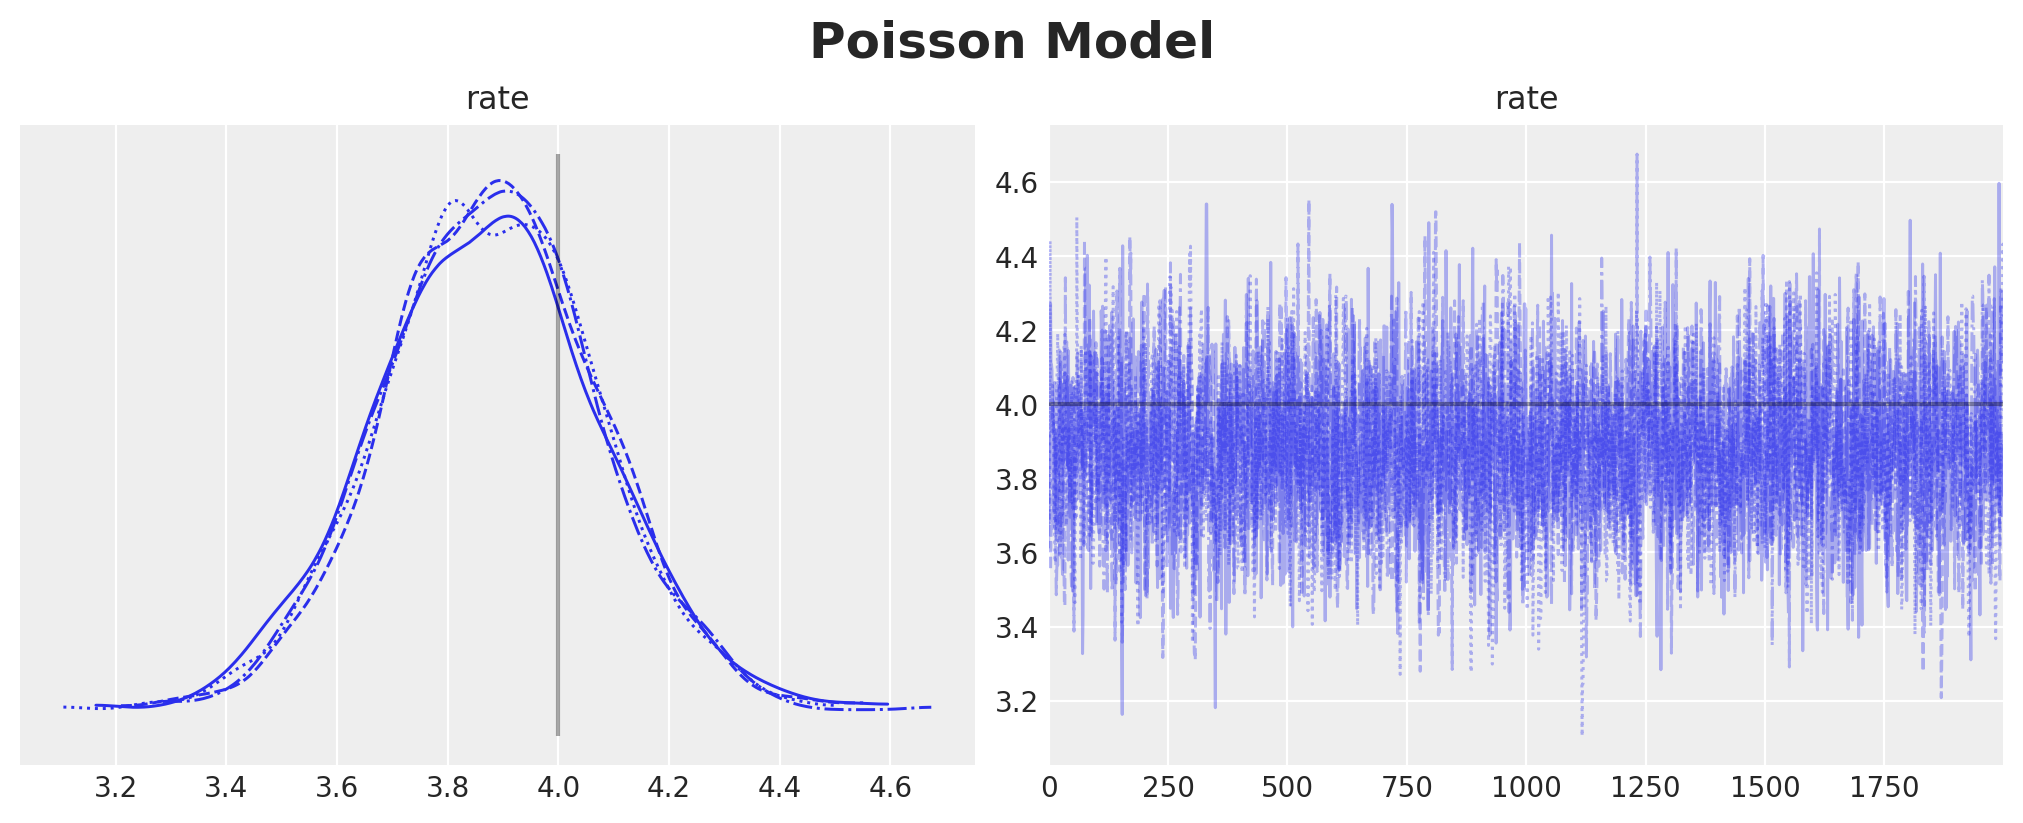

In [138]:
axes = az.plot_trace(
    data=poisson_idata,
    compact=True,
    lines=[("rate", {}, censored_poisson_data_params.rate)],
    backend_kwargs={"figsize": (10, 4), "layout": "constrained"},
)
plt.gcf().suptitle("Poisson Model", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Poisson Model Parameter')

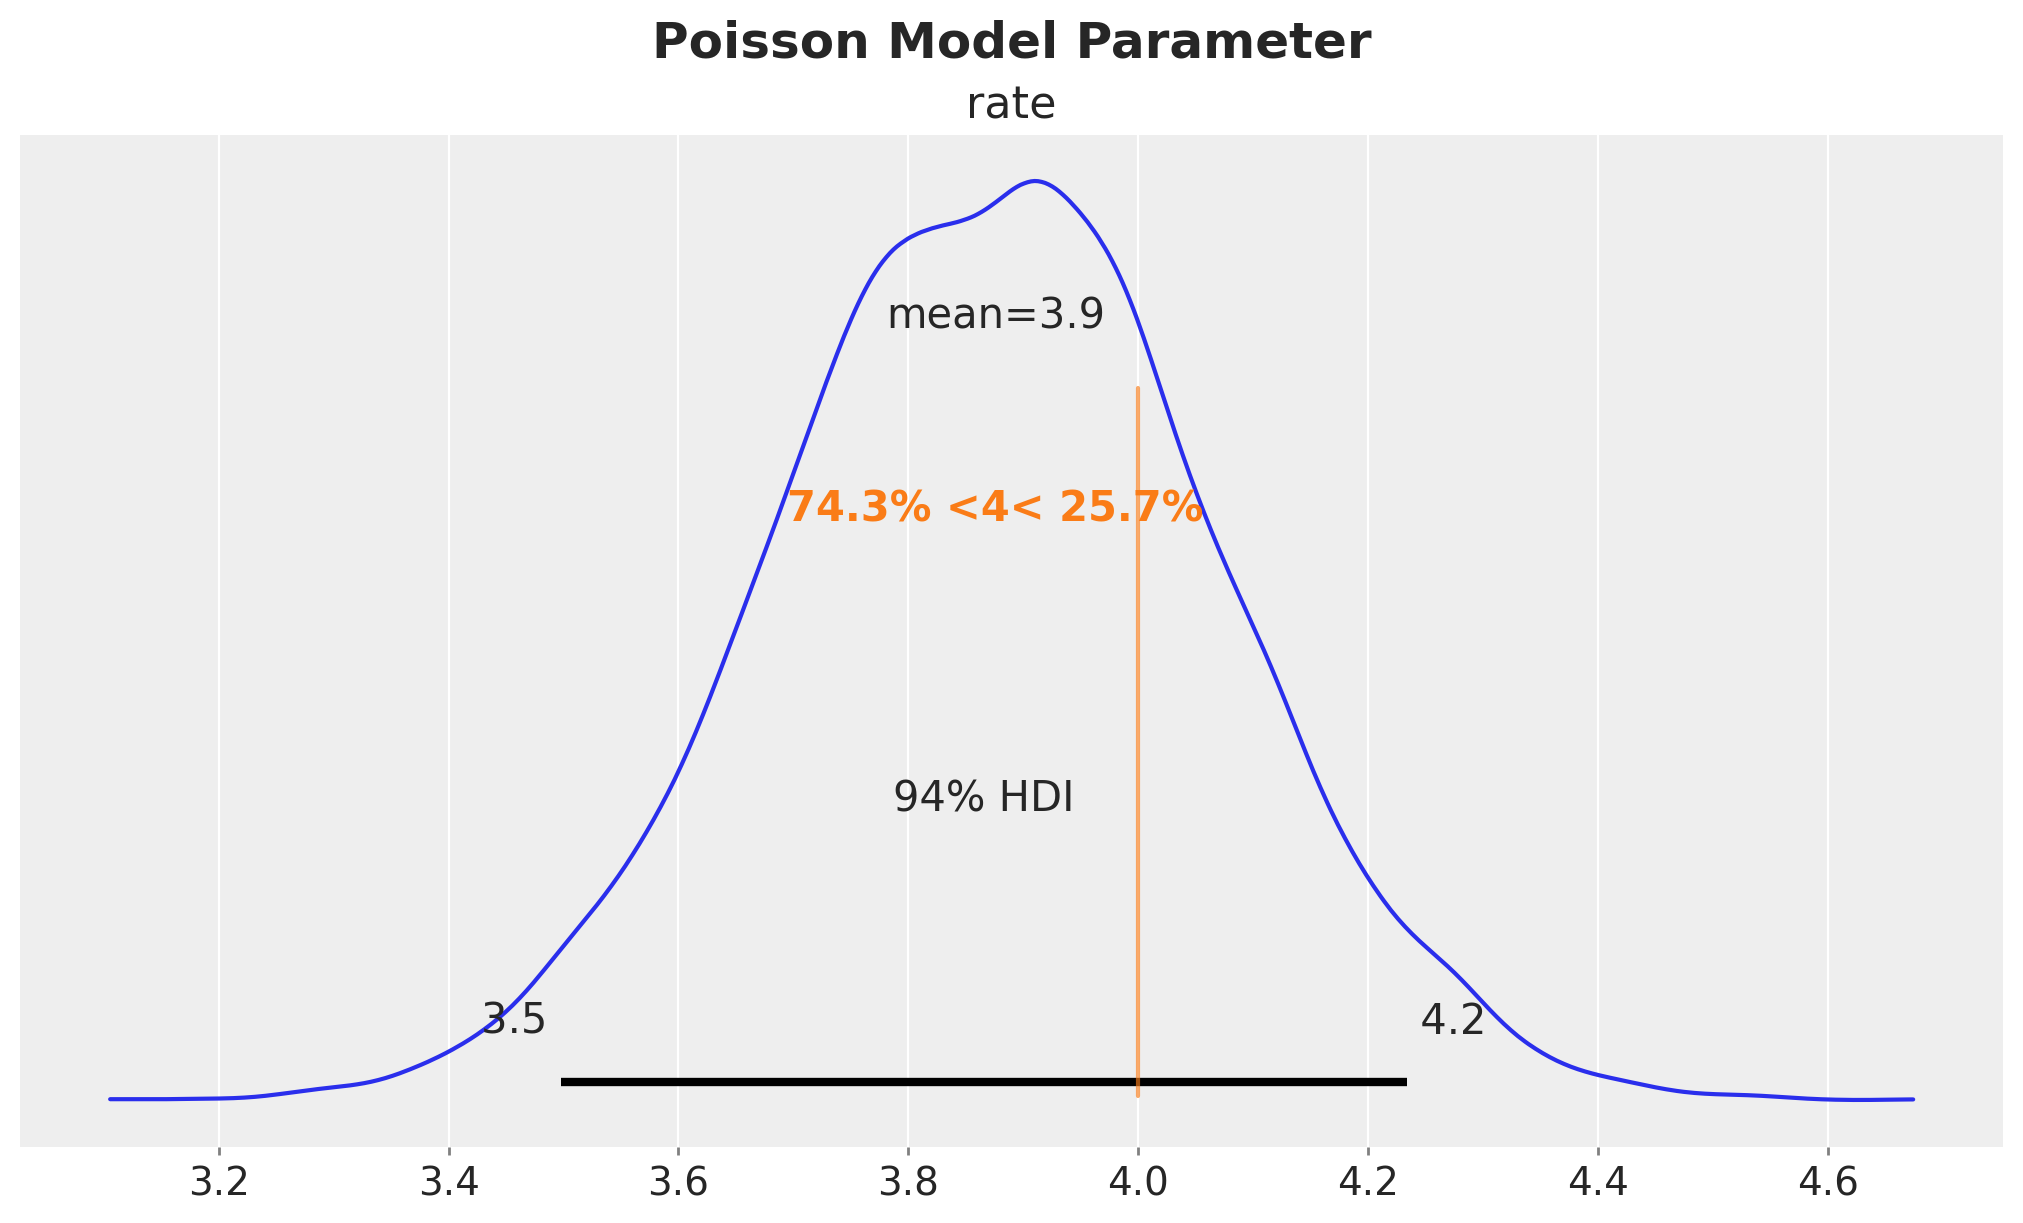

In [139]:
axes = az.plot_posterior(
    data=poisson_idata,
    ref_val=[censored_poisson_data_params.rate],
    round_to=2,
    figsize=(10, 6),
)
plt.gcf().suptitle("Poisson Model Parameter", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Poisson Model')

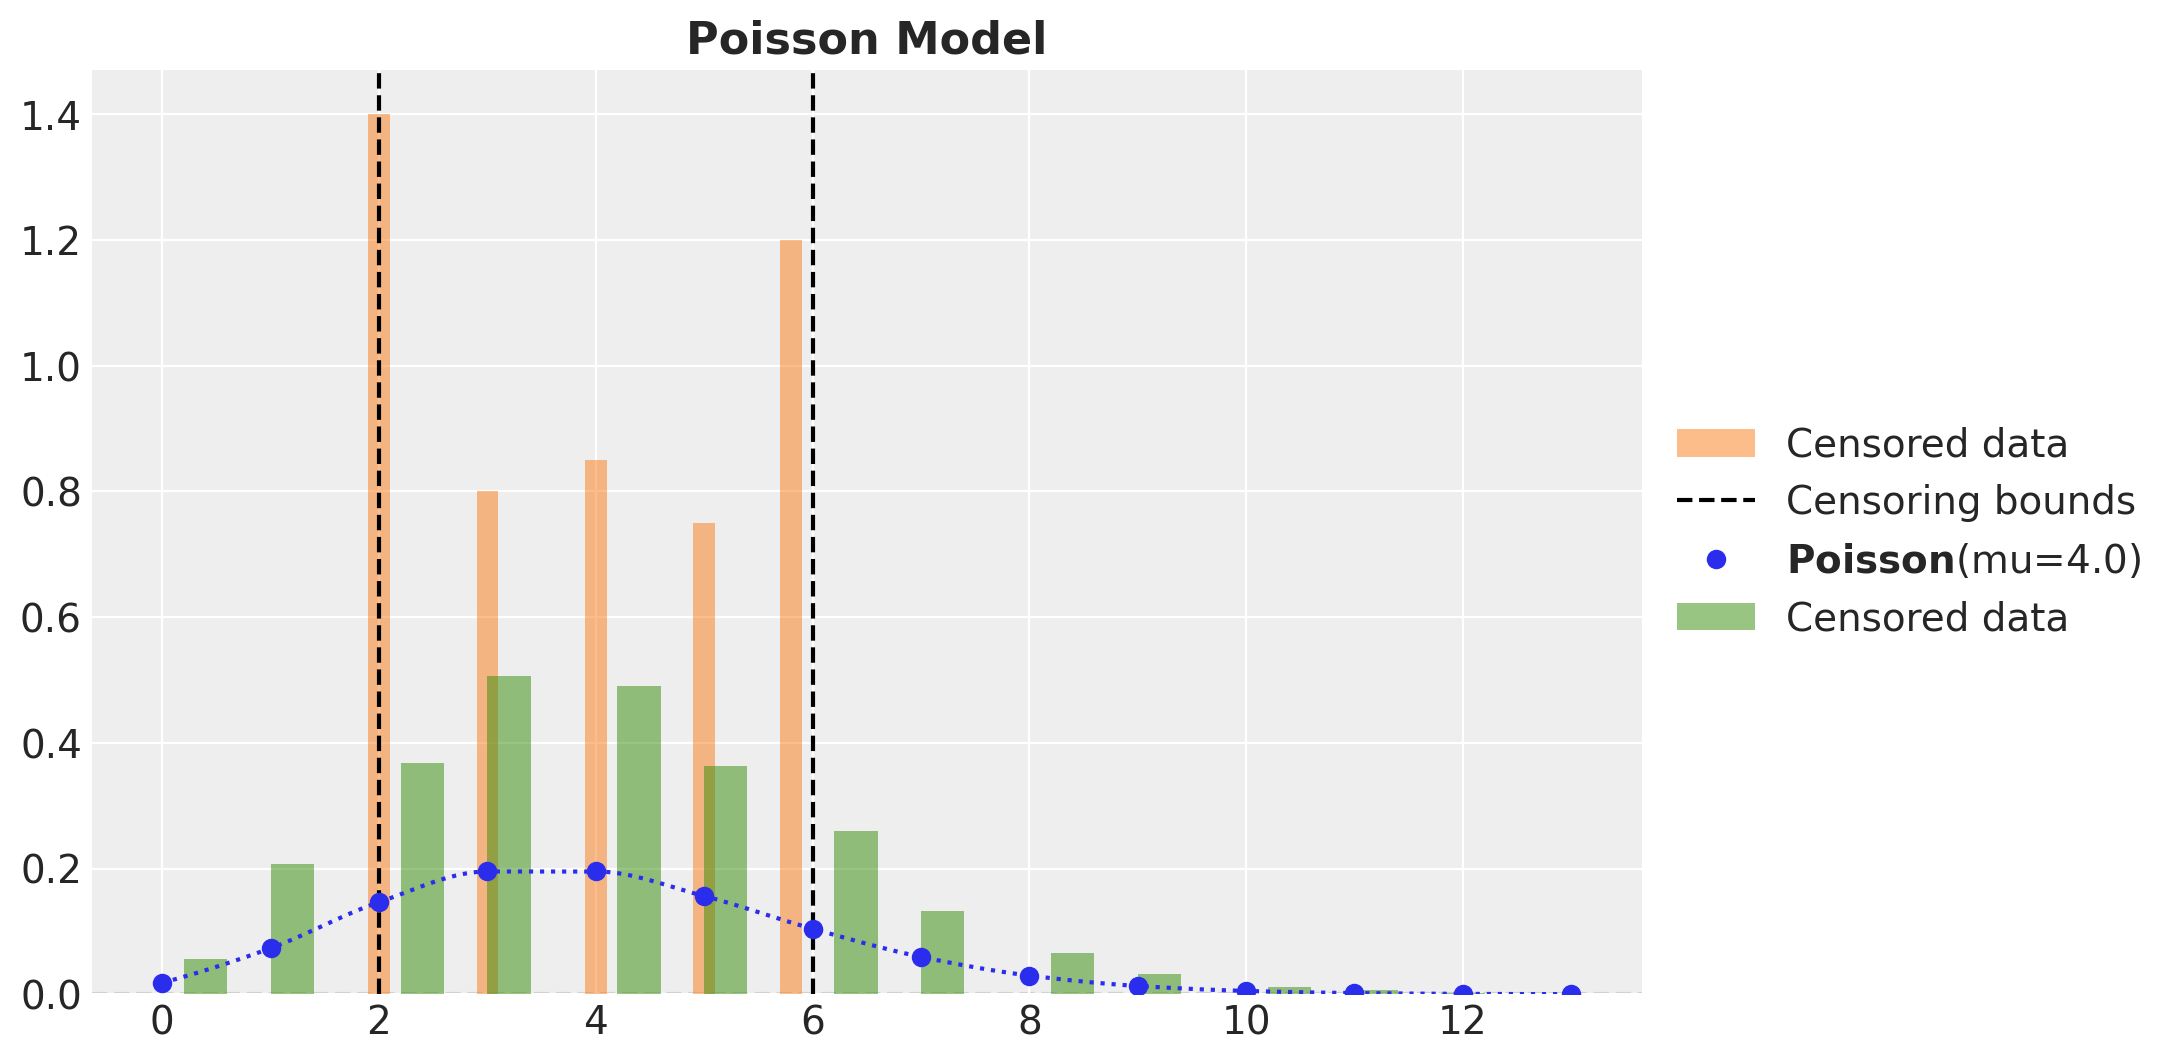

In [140]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    poisson_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    bins=30,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Censored data",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Poisson Model", fontsize=16, fontweight="bold")

## Censored Poisson Model

In [122]:
truncation_label = get_gamma_truncation_label(
    y=censored_poisson_samples,
    lower=censored_poisson_data_params.lower,
    upper=censored_poisson_data_params.upper,
)

In [123]:
def censored_poisson_model(
    y: ArrayImpl, lower: float, upper: float, truncation_label: ArrayImpl
) -> None:
    rate = numpyro.sample("rate", dist.Exponential(1.0))

    distribution = dist.Poisson(rate)

    with mask(mask=truncation_label == -1):
        cdf_lower = distribution.cdf(lower)
        pmf_lower = jnp.exp(distribution.log_prob(lower))
        truncation_prob_lower = cdf_lower + pmf_lower
        numpyro.sample(
            "truncated_label_lower", dist.Bernoulli(truncation_prob_lower), obs=1
        )

    with mask(mask=truncation_label == 0):
        numpyro.sample("obs", distribution, obs=y)

    with mask(mask=truncation_label == 1):
        ccdf_upper = 1 - distribution.cdf(upper)
        pmf_upper = jnp.exp(distribution.log_prob(upper))
        truncation_prob_upper = ccdf_upper + pmf_upper
        numpyro.sample(
            "truncated_label_upper", dist.Bernoulli(truncation_prob_upper), obs=1
        )

In [124]:
censored_poisson_kernel = NUTS(censored_poisson_model)
censored_poisson_mcmc = MCMC(
    censored_poisson_kernel,
    num_warmup=inference_params.num_warmup,
    num_samples=inference_params.num_samples,
    num_chains=inference_params.num_chains,
)
rng_key, rng_subkey = random.split(rng_key)
censored_poisson_mcmc.run(
    rng_key,
    y=censored_poisson_samples,
    lower=censored_poisson_data_params.lower,
    upper=censored_poisson_data_params.upper,
    truncation_label=truncation_label,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [125]:
censores_poisson_predictive = Predictive(
    model=censored_poisson_model,
    posterior_samples=censored_poisson_mcmc.get_samples(),
    return_sites=["obs"],
)
rng_key, rng_subkey = random.split(rng_key)
censored_poisson_posterior_predictive = censores_poisson_predictive(
    rng_subkey,
    y=None,
    lower=censored_poisson_data_params.lower,
    upper=censored_poisson_data_params.upper,
    truncation_label=truncation_label,
)

censored_poisson_idata = az.from_numpyro(posterior=censored_poisson_mcmc)
censored_poisson_idata.extend(
    az.from_numpyro(posterior_predictive=censored_poisson_posterior_predictive)
)

Text(0.5, 0.98, 'Censored Poisson Model')

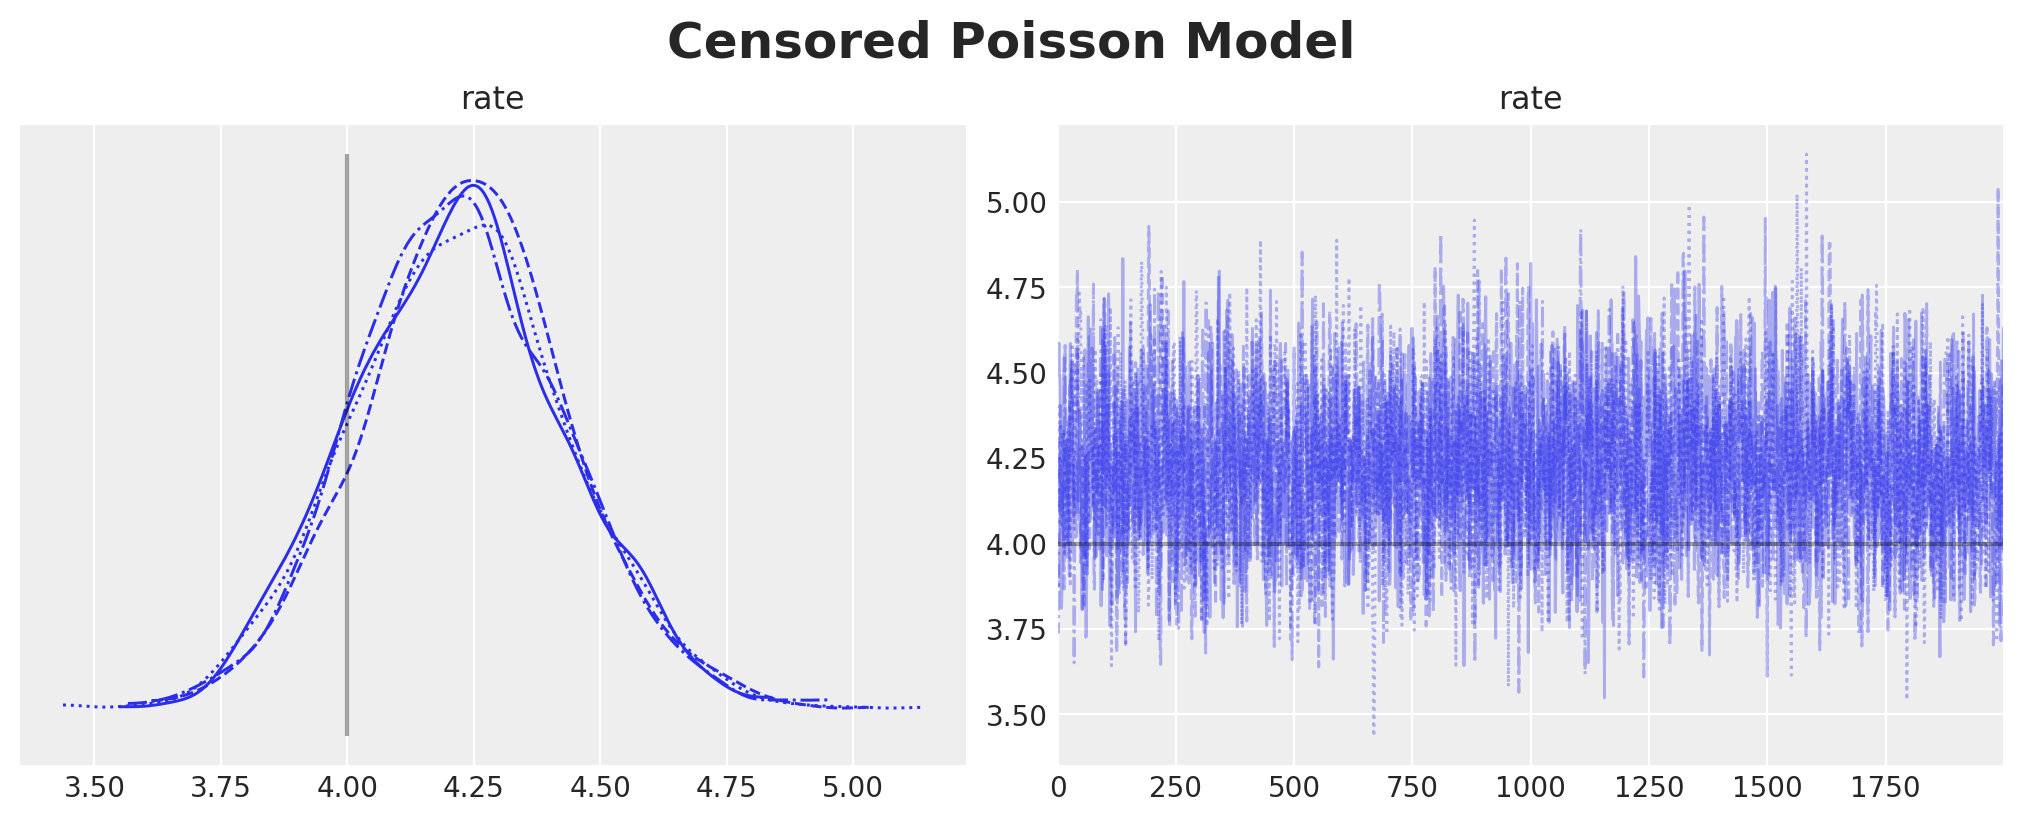

In [126]:
axes = az.plot_trace(
    data=censored_poisson_idata,
    compact=True,
    lines=[("rate", {}, censored_poisson_data_params.rate)],
    backend_kwargs={"figsize": (10, 4), "layout": "constrained"},
)
plt.gcf().suptitle("Censored Poisson Model", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Censored Poisson Model Parameters')

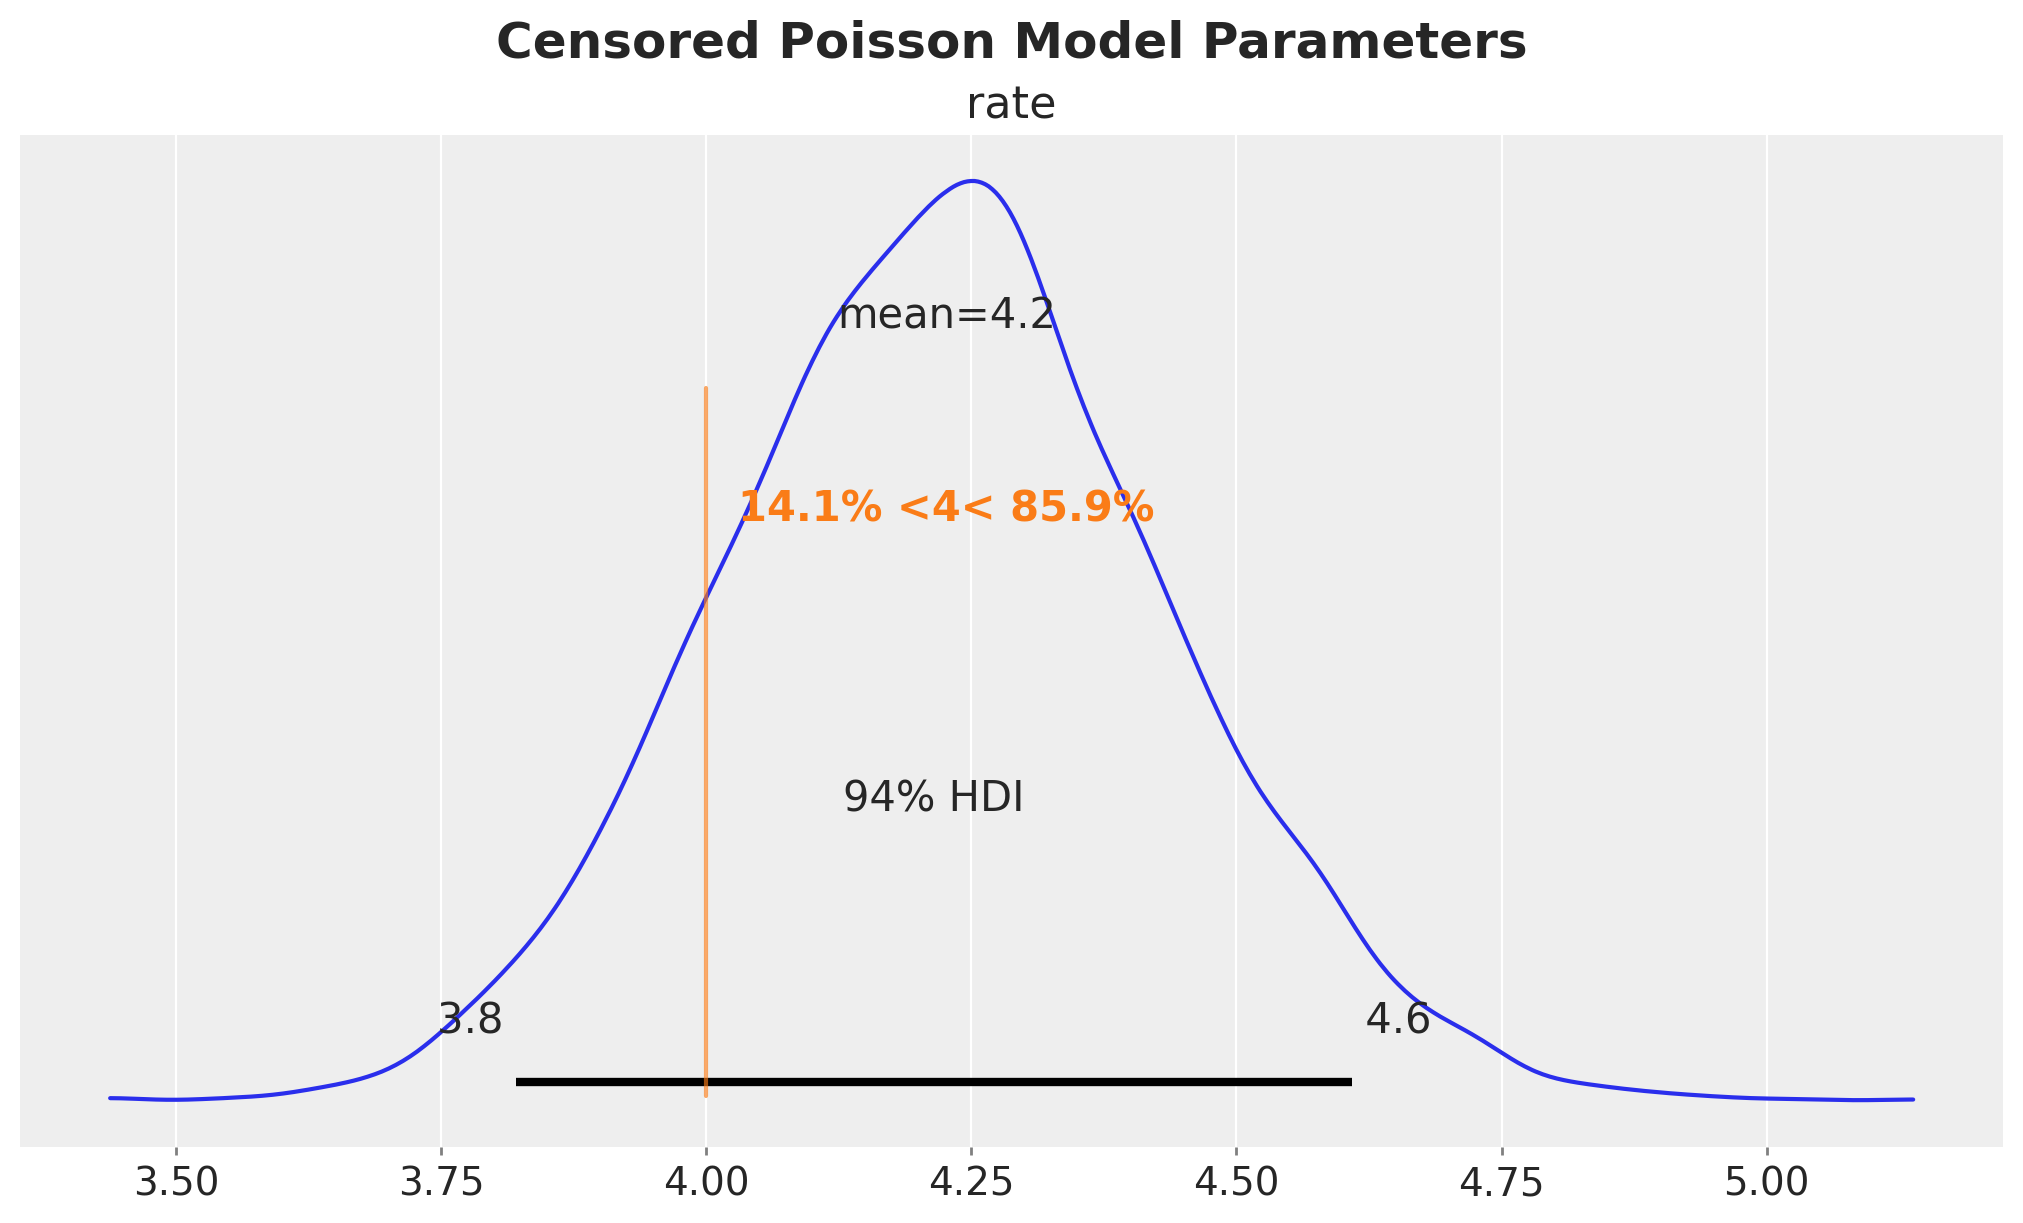

In [127]:
axes = az.plot_posterior(
    data=censored_poisson_idata,
    ref_val=[censored_poisson_data_params.rate],
    round_to=2,
    figsize=(10, 6),
)
plt.gcf().suptitle("Censored Poisson Model Parameters", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Censored Poisson Model (no clipping)')

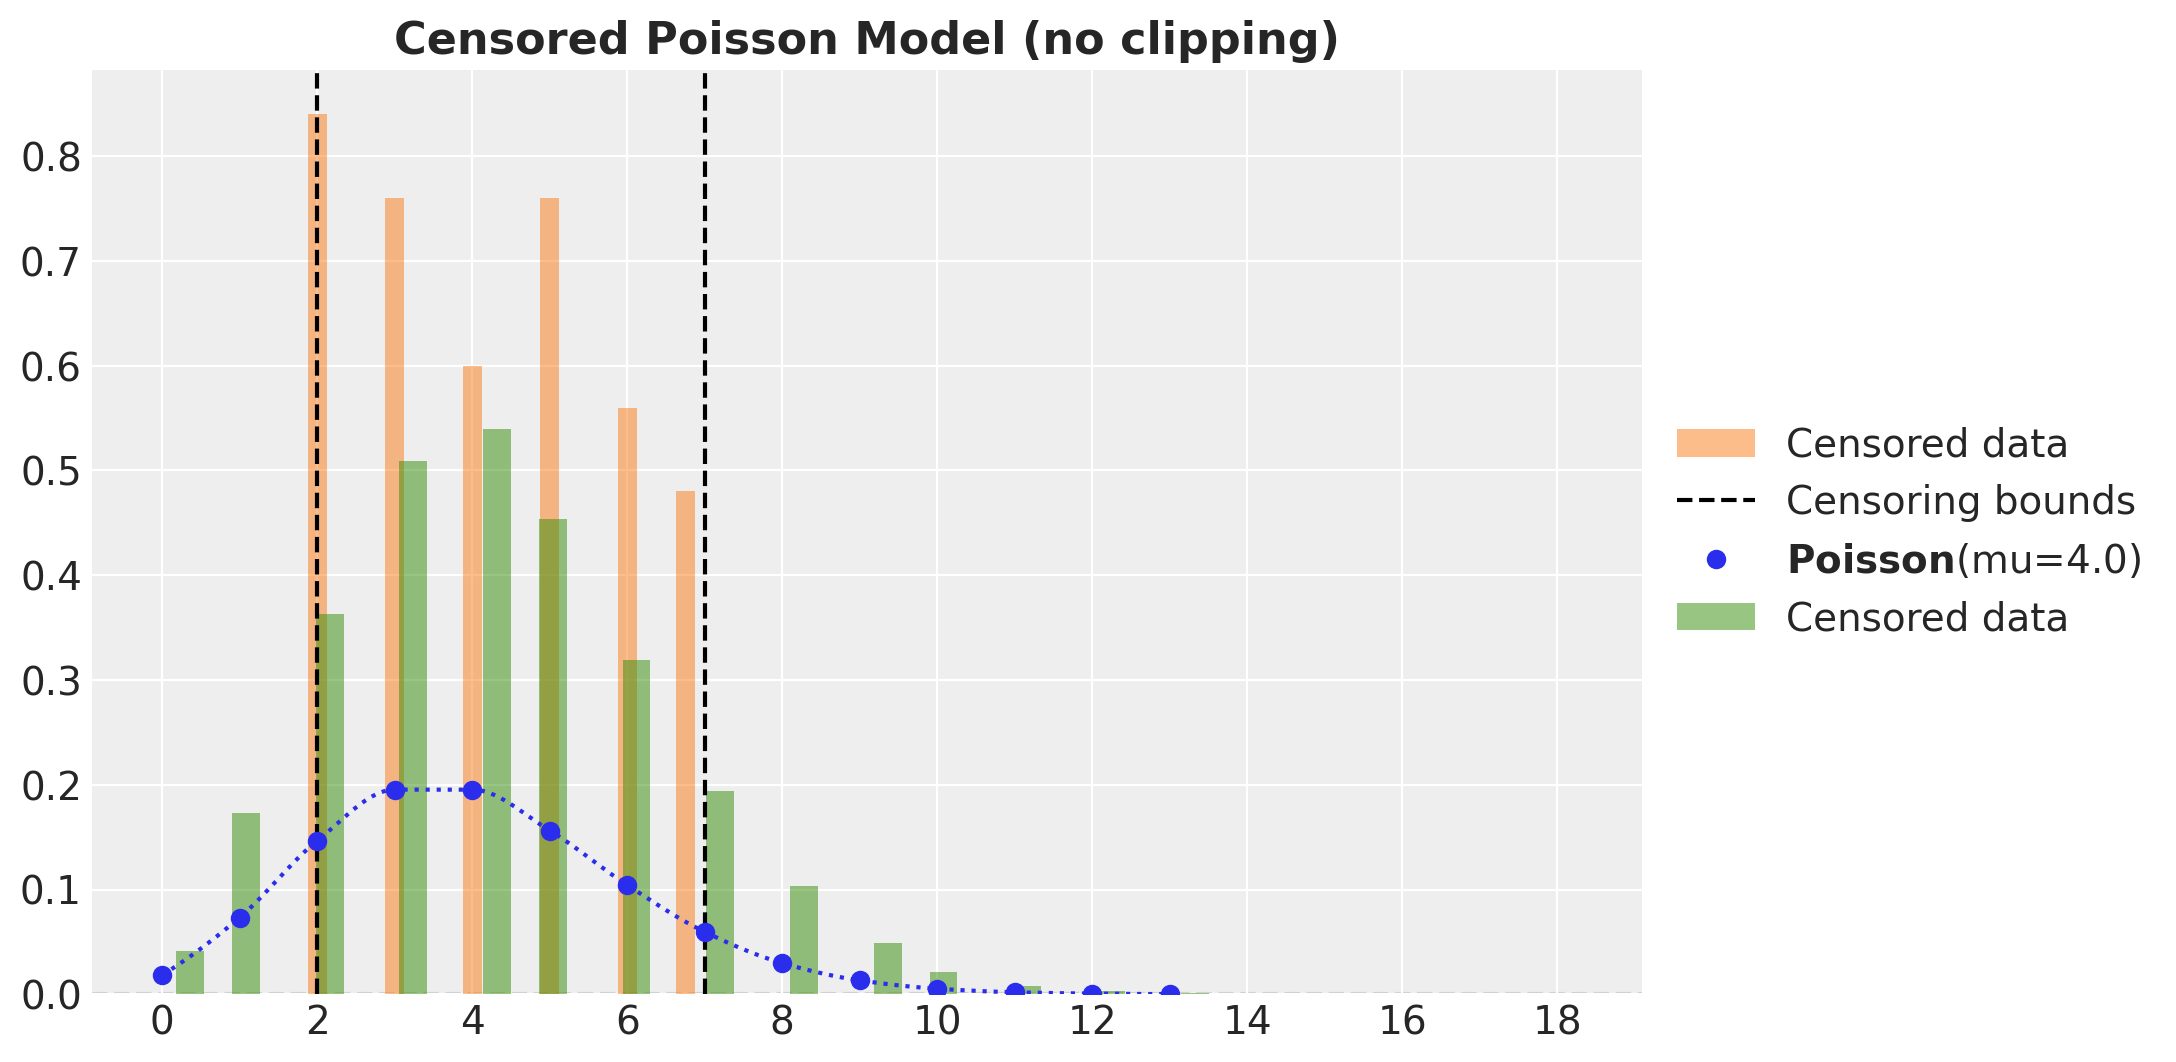

In [128]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    censored_poisson_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    bins=50,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Censored data",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Poisson Model (no clipping)", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'Censored Poisson Model')

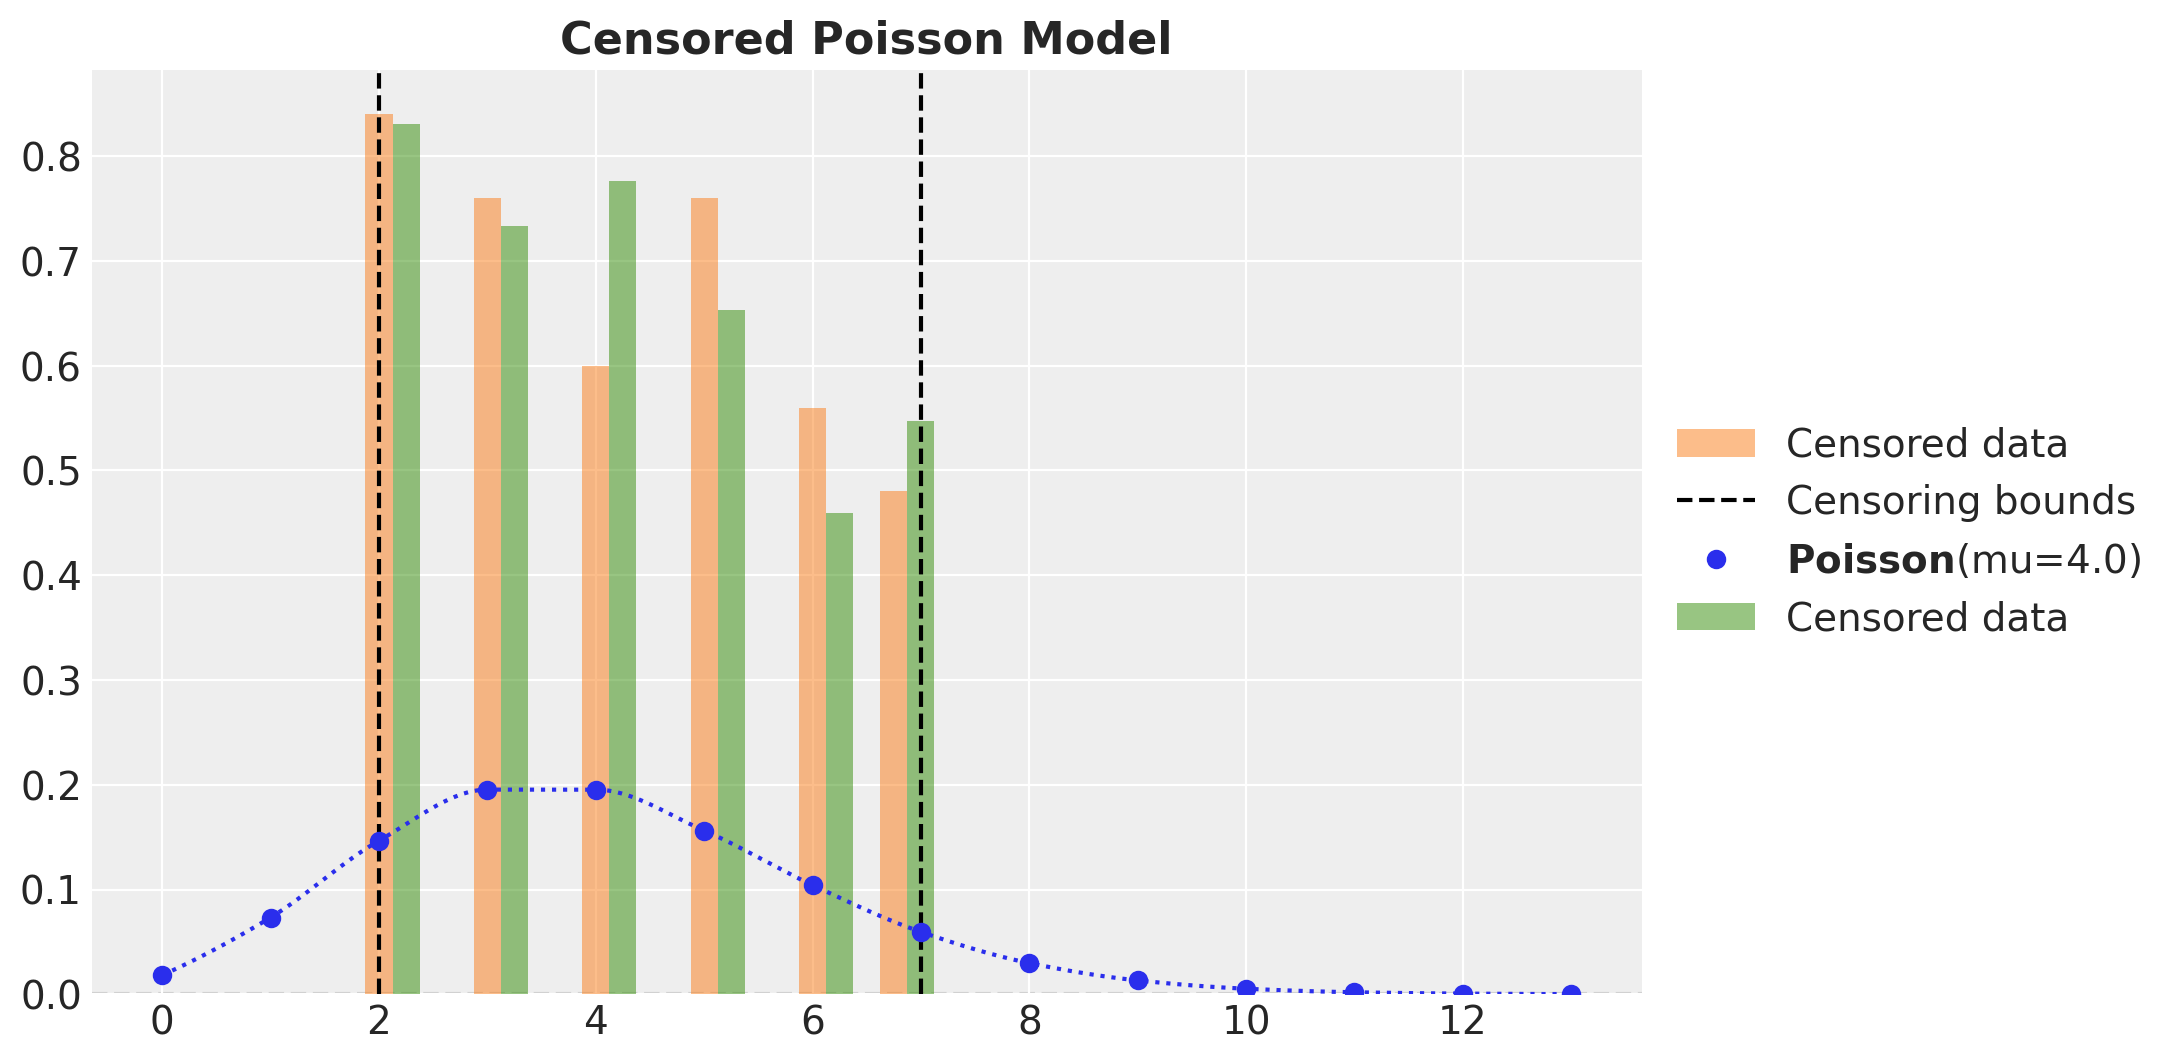

In [129]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    censored_poisson_idata["posterior_predictive"]["obs"]
    .clip(
        min=censored_poisson_data_params.lower, max=censored_poisson_data_params.upper
    )
    .to_numpy()
    .flatten(),
    bins=20,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Censored data",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Poisson Model", fontsize=16, fontweight="bold")

## Centered Poisson Model with PyMC

In [130]:
with pm.Model() as pymc_censored_poisson_model:
    rate = pm.Exponential("rate", lam=1.0)
    pm.Censored(
        "obs",
        dist=pm.Poisson.dist(mu=rate),
        lower=censored_poisson_data_params.lower,
        upper=censored_poisson_data_params.upper,
        observed=censored_poisson_samples,
    )

In [131]:
rng_key, rng_subkey = random.split(rng_key)

with pymc_censored_poisson_model:
    pymc_censored_poisson_idata = pm.sample(
        tune=inference_params.num_warmup,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

    pymc_censored_poisson_idata.extend(
        pm.sample_posterior_predictive(trace=pymc_censored_poisson_idata)
    )

Compiling...
Compilation time = 0:00:01.994166
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time = 0:00:04.432808
Transforming variables...
Transformation time = 0:00:00.074837
Sampling: [obs]


Text(0.5, 0.98, 'PyMC Censored Poisson Model')

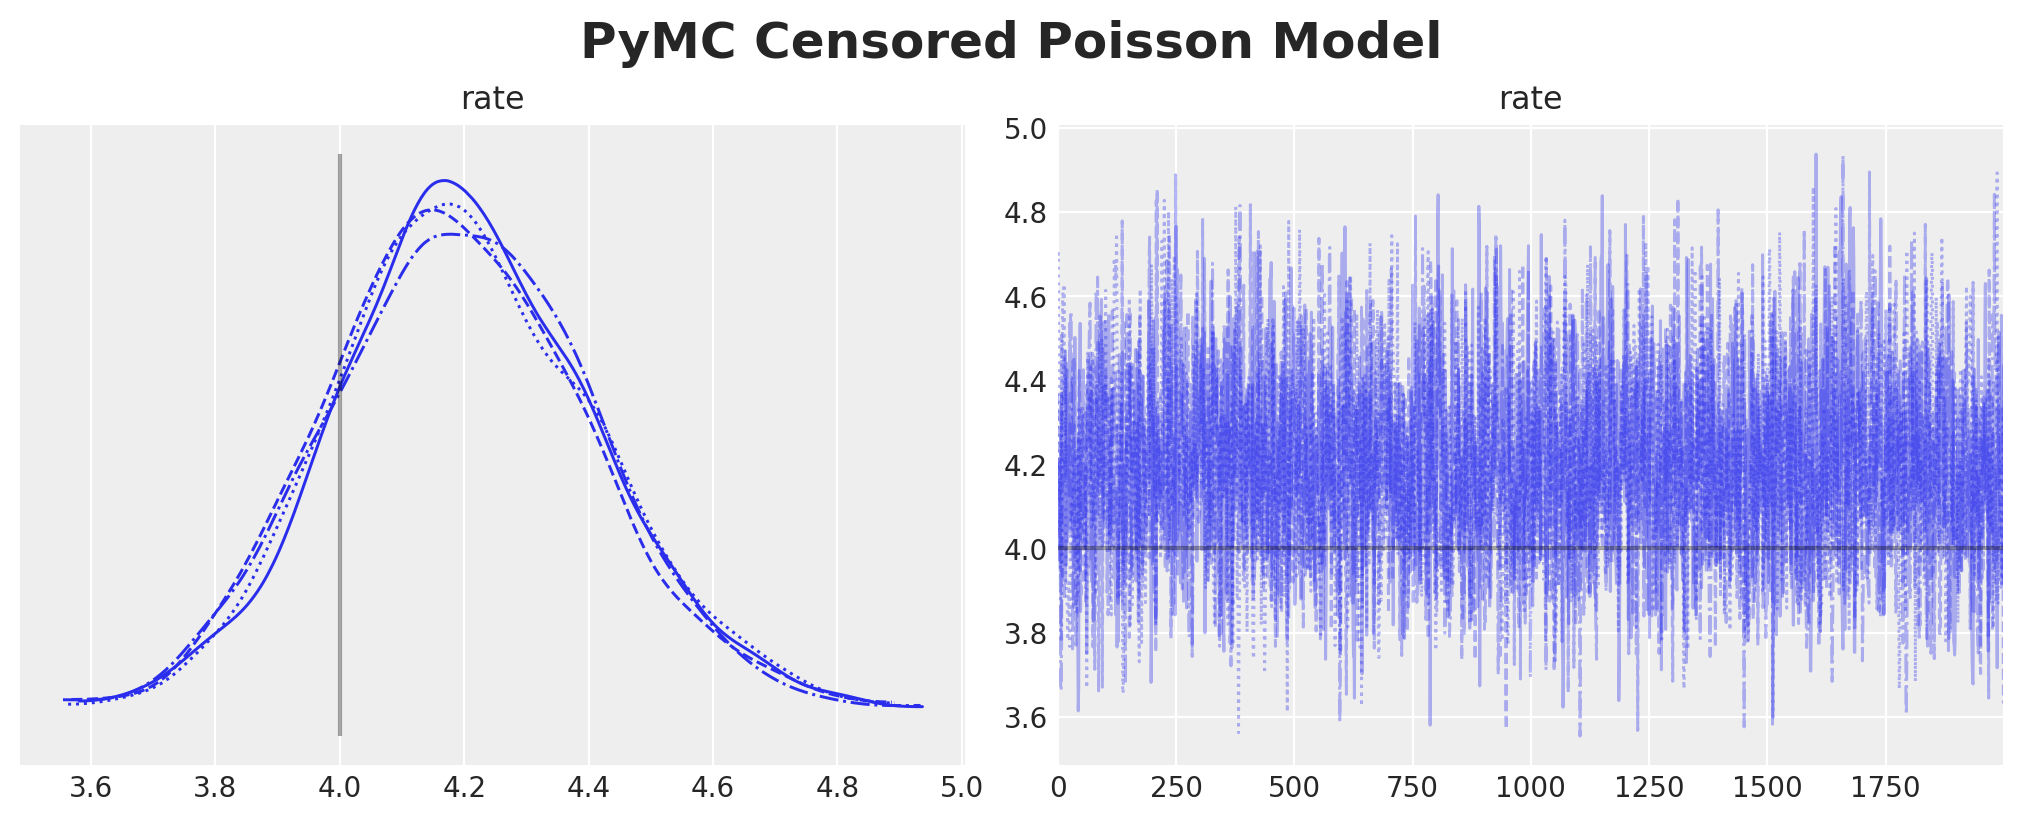

In [132]:
axes = az.plot_trace(
    data=pymc_censored_poisson_idata,
    compact=True,
    lines=[("rate", {}, censored_poisson_data_params.rate)],
    backend_kwargs={"figsize": (10, 4), "layout": "constrained"},
)
plt.gcf().suptitle("PyMC Censored Poisson Model", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'Censored Poisson PyMC Model Parameters')

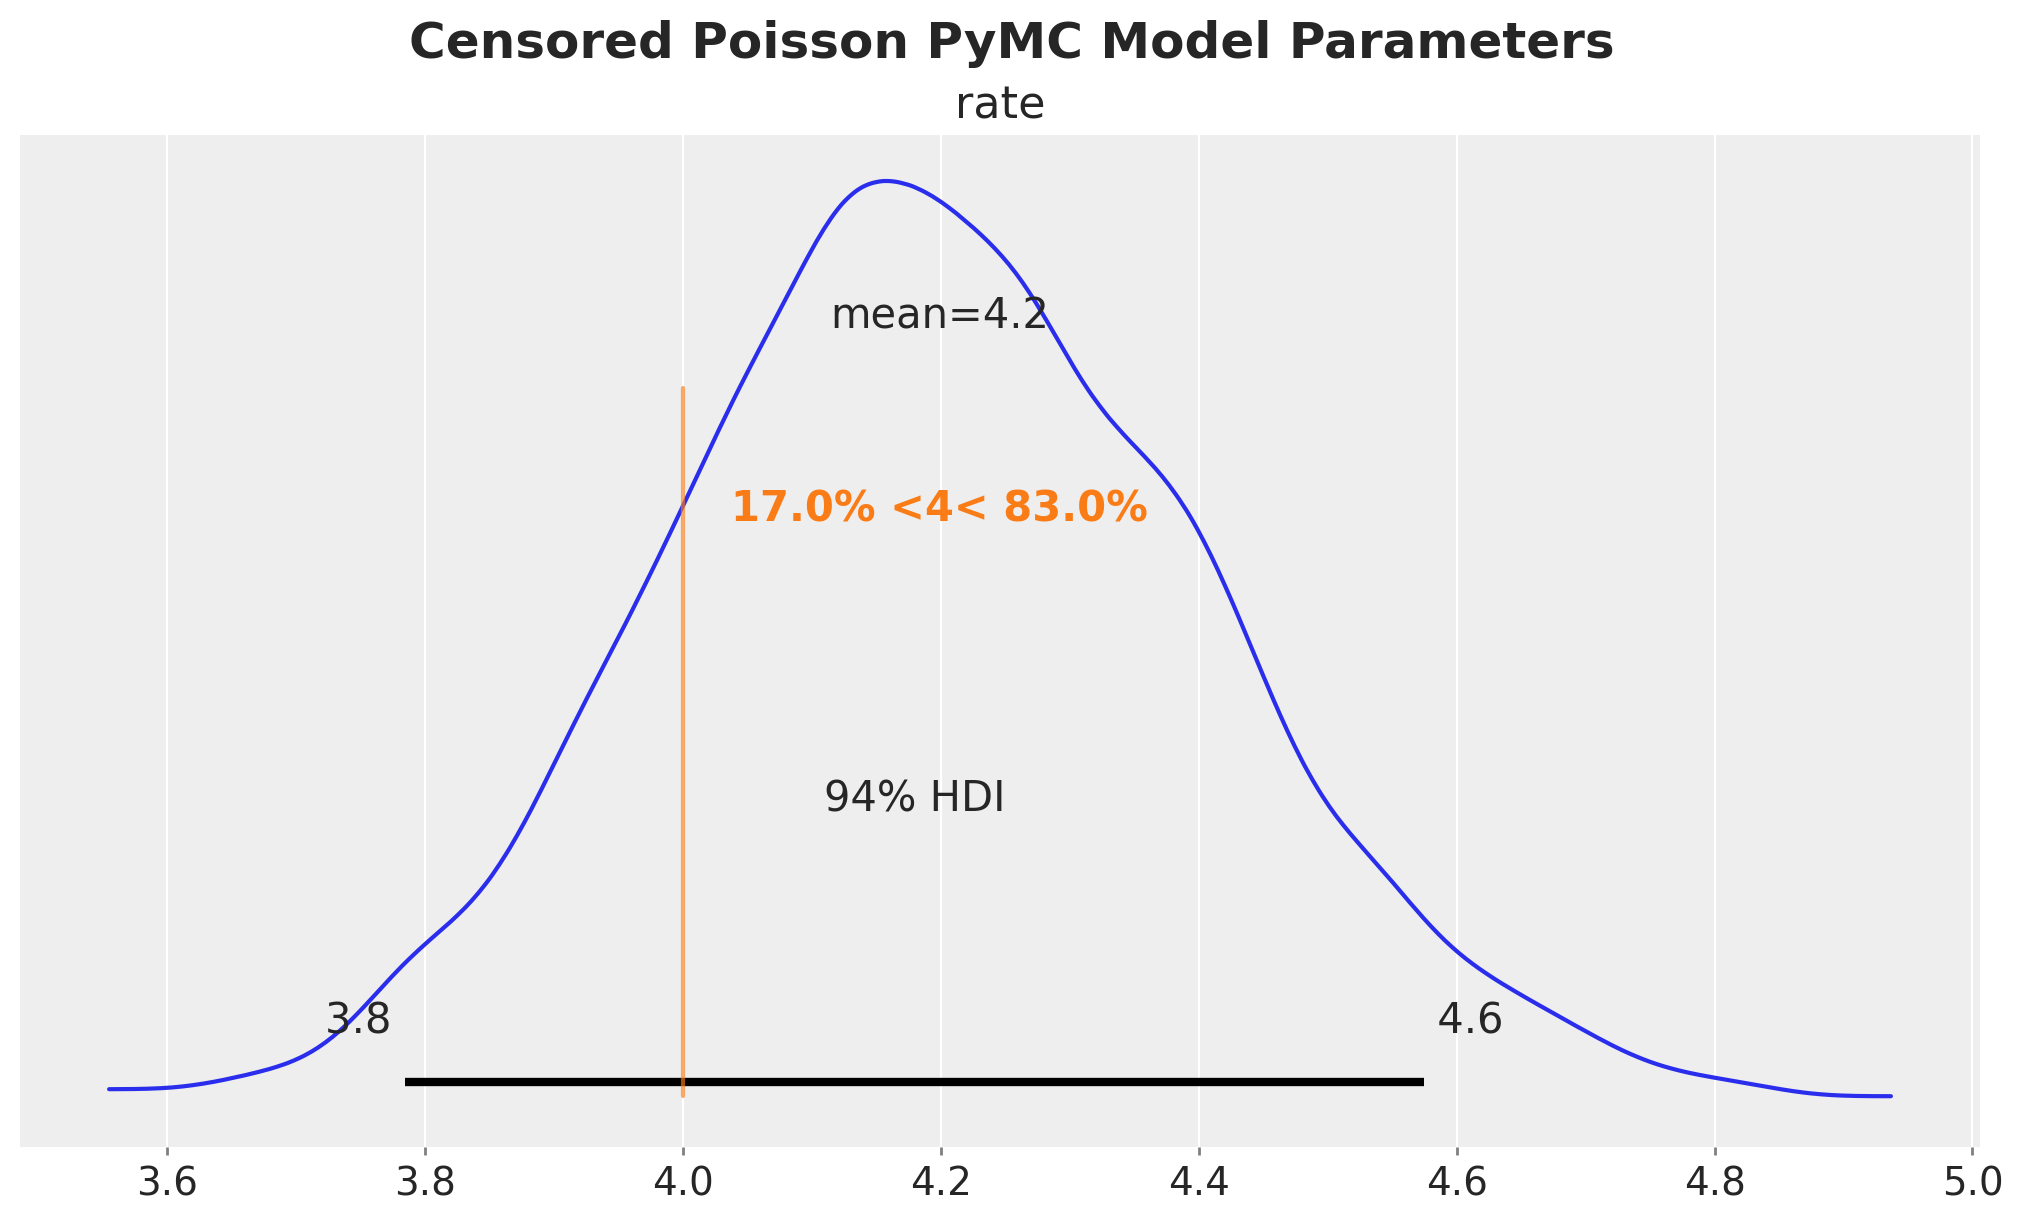

In [133]:
axes = az.plot_posterior(
    data=pymc_censored_poisson_idata,
    ref_val=[censored_poisson_data_params.rate],
    round_to=2,
    figsize=(10, 6),
)
plt.gcf().suptitle(
    "Censored Poisson PyMC Model Parameters", fontsize=18, fontweight="bold"
)

Text(0.5, 1.0, 'Censored Poisson PyMC Model')

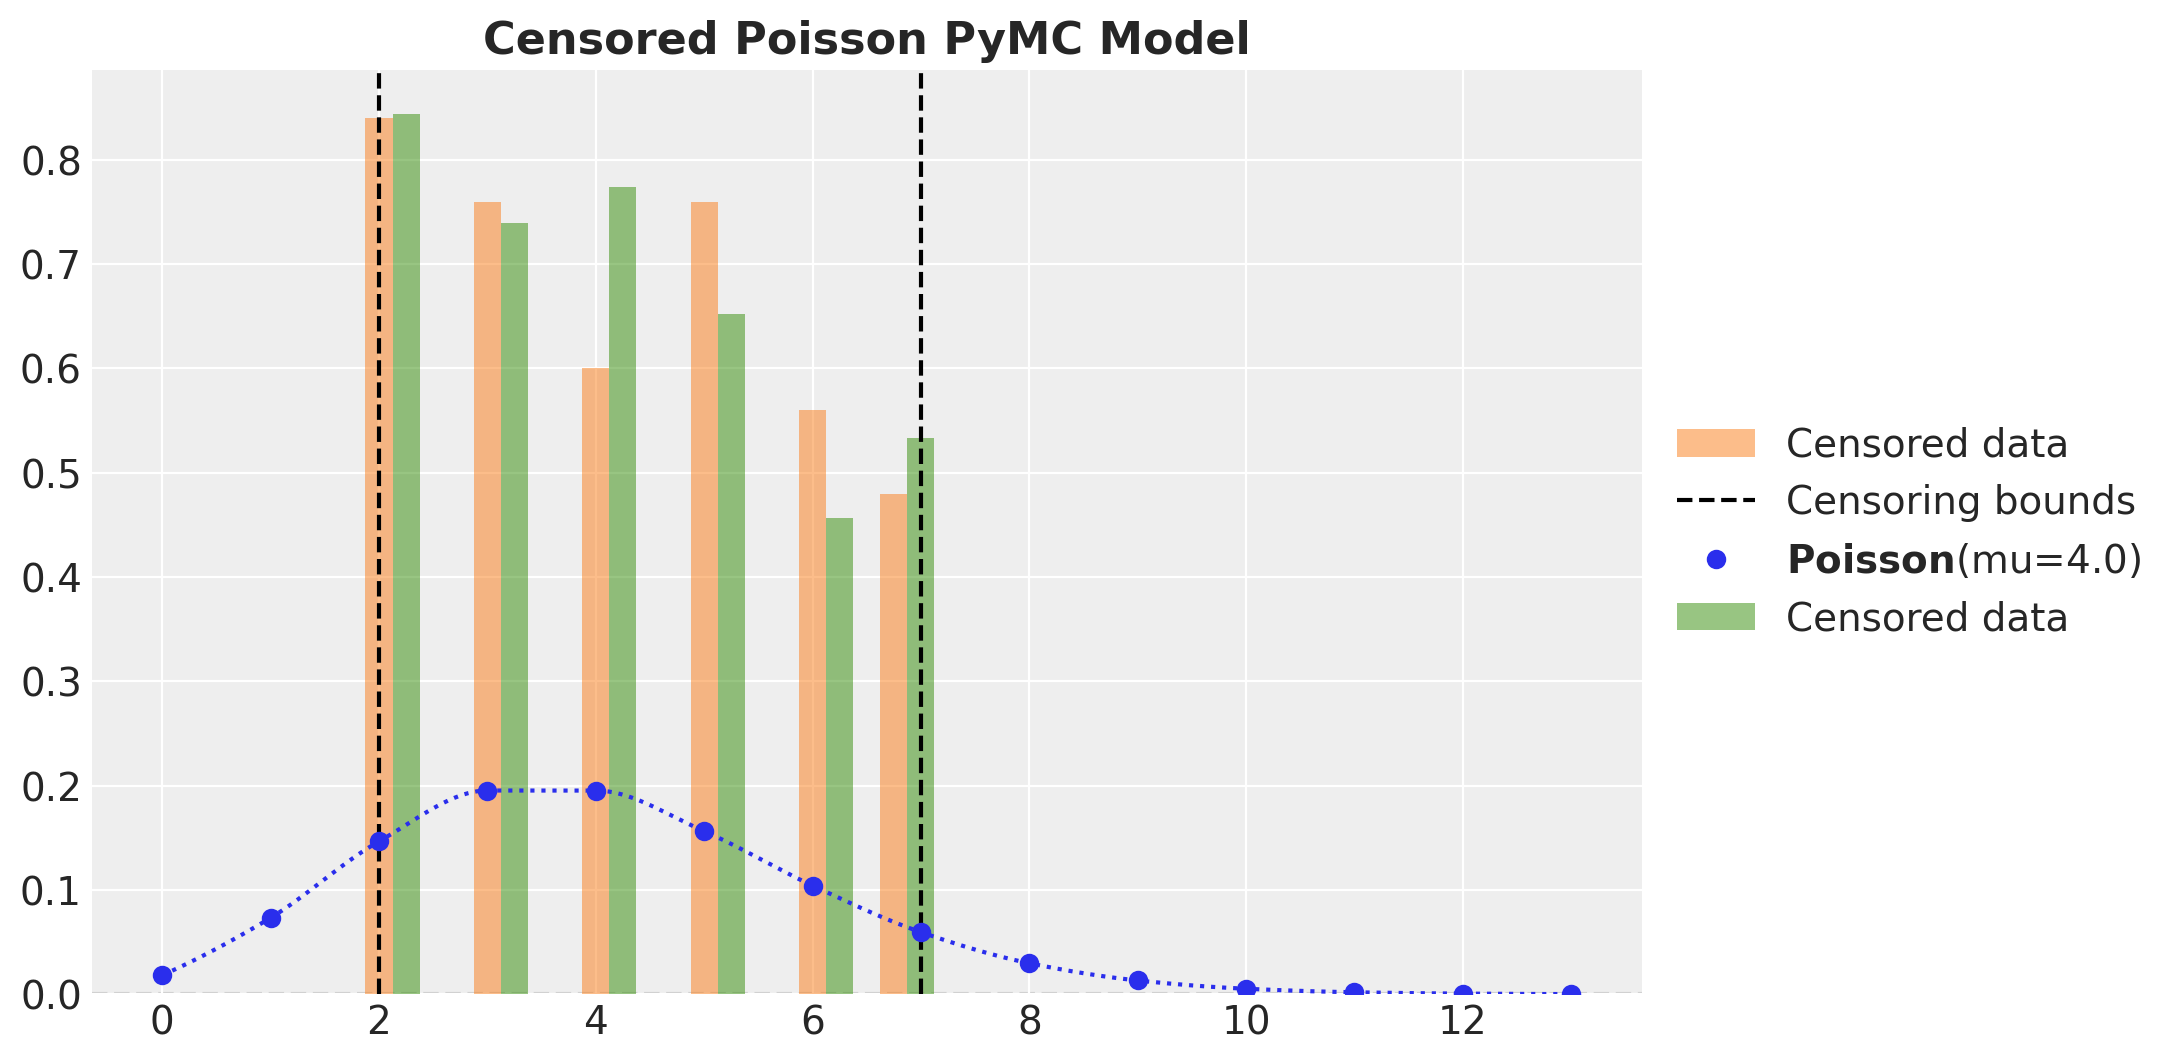

In [134]:
fig, ax = plt.subplots()
_ = ax.hist(
    censored_poisson_samples,
    bins=20,
    density=True,
    align="left",
    color="C1",
    alpha=0.5,
    label="Censored data",
)
ax.axvline(censored_poisson_data_params.lower, color="k", linestyle="--")
ax.axvline(
    censored_poisson_data_params.upper,
    color="k",
    linestyle="--",
    label="Censoring bounds",
)
pz.Poisson(mu=censored_poisson_data_params.rate).plot_pdf(color="C0", ax=ax)
_ = ax.hist(
    pymc_censored_poisson_idata["posterior_predictive"]["obs"].to_numpy().flatten(),
    bins=20,
    density=True,
    align="right",
    color="C2",
    alpha=0.5,
    label="Censored data",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Censored Poisson PyMC Model", fontsize=16, fontweight="bold")